In [15]:
from sklearn.datasets import load_svmlight_file
from math import sqrt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import cosine_distances
from sklearn.metrics import classification_report
from sklearn.cluster import KMeans
from gensim.models.doc2vec import Doc2Vec
from sklearn.datasets import dump_svmlight_file

import matplotlib.pyplot as plt
import random
import os
import time
import datetime
import numpy as np

# Distance
## Euclidean distance
<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/dc0281a964ec758cca02ab9ef91a7f54ac00d4b7">
## Cosine distance
<img src = "https://wikimedia.org/api/rest_v1/media/math/render/svg/a71c4add4abded66efd42b202c76f6a59944a587">

In [2]:
def euclideanDistance(a, b):
    
    temp = a - b
    temp = temp.multiply(temp)
    squaredSum = temp.sum()
    return sqrt(squaredSum)

In [3]:
def cosineDistance(a, b):
    
    temp = (a.multiply(b)).sum()
    normA = sqrt((a.multiply(a)).sum())
    normB = sqrt((b.multiply(b)).sum())
    """1 - cosineSimilarity"""
    return 1.0 - (temp/(normA * normB))

# K-means
<img src = "https://wikimedia.org/api/rest_v1/media/math/render/svg/8dc15ec63e0676fc07e790f61efd89484a6b7922">

## Cluster

## KMeans

In [4]:
"""Will only store indices. This is more efficient"""
class Cluster:
    
    def __init__(self, center, index):
        self.itemIndices = []
        self.mean = center
        self.itemIndices.append(index)
        
    def add(self, index):
        if index not in self.itemIndices:
            self.itemIndices.append(index)
    
    def remove(self, index):
        if index in self.itemIndices:
            self.itemIndices.remove(index)
    
    def contains(self, index):
        if index in self.itemIndices:
            return True
        else:
            return False
    
    def recenter(self, x):
        tmp = 0
        
        for index in self.itemIndices:
            tmp = tmp + x[index]
        self.mean = tmp/(len(self.itemIndices))
    
    def generateClusterLabel(self, y):
        
        self.frequencyDictionary = {}
        
        for index in self.itemIndices:
            if y[index] in self.frequencyDictionary:
                self.frequencyDictionary[y[index]] = self.frequencyDictionary[y[index]] + 1
            else:
                self.frequencyDictionary[y[index]] = 1
        
        target = None
        maxTargetFrequency = 0
        
        for key in self.frequencyDictionary:
            if self.frequencyDictionary[key] > maxTargetFrequency:
                target = key
                maxTargetFrequency = self.frequencyDictionary[key]
        self.target = target
    
    def plotCluster(self):
        val, weight = zip(*[(k, v) for k,v in self.frequencyDictionary.items()])
        plt.figure(figsize=(20, 10))
        plt.hist(val, weights=weight)
        plt.title("Cluster with target "+str(self.target))
        plt.xticks(list(self.frequencyDictionary.keys()))
        plt.xlabel("Class")
        plt.ylabel("Frequency")
        plt.show()
    
    def clusterDistortion(self, x):
        distortion = 0
        for index in self.itemIndices:
            distortion = distortion + euclideanDistance(x[index], self.mean)
        return distortion
    

In [5]:
class KmeansCluster:
    
    k = None
    distanceMetric = None
    clusters = None
    
    """Get distance from all clusters"""
    def getClusterDistance(self, x):
        
        distanceList = []
        for cluster in self.clusters:
            distanceList.append(self.distanceMetric(cluster.mean, x))
        return distanceList
        
    """Will fit on the training data"""
    def __init__(self, x, y = None, distanceMetric = euclideanDistance, k = 10, maxEpochs = 100):
        
        self.distanceMetric = distanceMetric
        self.k = k
        self.clusters = []
        
        """Create initial cluster randomly"""
        randomIndex = random.randint(0, x.shape[0] - 1)
        cluster = Cluster(x[randomIndex], randomIndex)
        self.clusters.append(cluster)
        
        """Generate subsequent clusters"""
        for i in range(1, self.k):
            print("Cluster-"+str(i+1))
            ptr = 0
            distanceMetric = []
            
            for dataPoint in x:
                
                ptr = ptr + 1
                if ptr%200 == 0:
                    time.sleep(0.05)
   
                clusterDistance = self.getClusterDistance(dataPoint)
                distanceMetric.append(sum(clusterDistance))
            
            """Find the index with max distance"""
            index = distanceMetric.index(max(distanceMetric))
            
            """Create a cluster and add to list"""
            cluster = Cluster(x[index], index)
            self.clusters.append(cluster)
        
        """Clusters are created Now normalizing the clusters"""
        
        for i in range(0, maxEpochs):
            
            print("Epoch-"+str(i))
            clusterUpdated = False
            ptr = 0
            
            for dataPointIndex, dataPoint in enumerate(x):
                ptr = ptr + 1
                if ptr%200 ==0:
                    time.sleep(0.05)
                clusterDistance = self.getClusterDistance(dataPoint)
                """Select cluster with minimum distance"""
                candidateClusterIndex = clusterDistance.index(min(clusterDistance))
                
                if not self.clusters[candidateClusterIndex].contains(dataPointIndex):
                    clusterUpdated = True
                    
                    for cluster in self.clusters:
                        if cluster.contains(dataPointIndex):
                            cluster.remove(dataPointIndex)
                            break
                    
                    self.clusters[candidateClusterIndex].add(dataPointIndex)
                
            if clusterUpdated:
                """Calculate new mean"""
                for cluster in self.clusters:
                    cluster.recenter(x)
            else:
                print("KMeans converged")
                break
        
        """Calculate cluster quality"""
        distortion = 0
        for cluster in self.clusters:
            distortion = distortion + cluster.clusterDistortion(x)
        self.distortion = distortion
        
        """Cluster converged. Generate labels"""
        if y is not None:
            for cluster in self.clusters:
                cluster.generateClusterLabel(y)
        
    def plotClusterQuality(self):
        
        for cluster in self.clusters:
            cluster.plotCluster()
    
    def predict(self, x):
        yPrediction = []
        
        for datapoint in x:
            clusterDistance = self.getClusterDistance(dataPoint)
            candidateIndex = clusterDistance.index(min(clusterDistance))
            yPrediction.append(self.clusters[candidateIndex].target)
        return yPrediction

## Optimized version of above code
The above code will take a lot of time as it is iterating over dataset. Will remove the iterations by calculating the distance on complete dataset

In [6]:
def euclideanDistanceSKLearn(a, b):
    return euclidean_distances(a, b).flatten()

In [7]:
def cosineDistanceSKLearn(a, b):
    return cosine_distances(a, b).flatten()

In [8]:
class KmeansOptimized:
    
    k = None
    distanceMetric = None
    clusters = None
    
    """Get distance from all clusters"""
    def getClusterDistance(self, x):
        
        distanceList = []
        for cluster in self.clusters:
            distanceList.append(self.distanceMetric(cluster.mean, x))
        return np.array(distanceList)
        
    """Will fit on the training data"""
    def __init__(self, x, y = None, distanceMetric = euclideanDistance, k = 10, maxEpochs = 100):
        
        self.distanceMetric = distanceMetric
        self.k = k
        self.clusters = []
        
        """Create initial cluster randomly"""
        randomIndex = random.randint(0, x.shape[0] - 1)
        cluster = Cluster(x[randomIndex], randomIndex)
        self.clusters.append(cluster)
        
        """Generate subsequent clusters"""
        for i in range(1, self.k):
            
            distanceMetric = []
            
            
            clusterDistance = self.getClusterDistance(x)
            clusterDistance = clusterDistance.sum( axis = 0)
            """Find the index with max distance"""
            index = np.where(clusterDistance == max(clusterDistance))[0][0]
            """Create a cluster and add to list"""
            cluster = Cluster(x[index], index)
            self.clusters.append(cluster)
            
            
        
        """Clusters are created Now normalizing the clusters"""
        
        for i in range(0, maxEpochs):
            
            clusterUpdated = False
            
            
            clusterDistance = self.getClusterDistance(x)
            clusterDistance = clusterDistance.T
            
            """Iteration but all distances are already computed This will optimize the execution"""
            for dataPointIndex, dataPointDistance in enumerate(clusterDistance):
                
                candidateClusterIndex = np.where(dataPointDistance == min(dataPointDistance))[0][0]
                
                if not self.clusters[candidateClusterIndex].contains(dataPointIndex):
                    clusterUpdated = True
                    
                    for cluster in self.clusters:
                        if cluster.contains(dataPointIndex):
                            cluster.remove(dataPointIndex)
                            break
                    
                    self.clusters[candidateClusterIndex].add(dataPointIndex)
                
            if clusterUpdated:
                """Calculate new mean"""
                for cluster in self.clusters:
                    cluster.recenter(x)
            else:
                print("KMeans converged")
                break
        
        """Calculate cluster quality"""
        distortion = 0
        for cluster in self.clusters:
            distortion = distortion + cluster.clusterDistortion(x)
        self.distortion = distortion
        
        """Cluster converged. Generate labels"""
        if y is not None:
            for cluster in self.clusters:
                cluster.generateClusterLabel(y)
        
    def plotClusterQuality(self):
        
        for cluster in self.clusters:
            cluster.plotCluster()
    
    def predict(self, x):
        yPrediction = []
        
        for dataPoint in x:
            clusterDistance = self.getClusterDistance(dataPoint)
            candidateIndex = np.where(clusterDistance == min(clusterDistance))[0][0]
            yPrediction.append(self.clusters[candidateIndex].target)
        return yPrediction

# Read data

In [9]:
def dataReader(basePath):
    y = []
    x = []
    
    for directory in os.listdir(basePath):
        for fileName in os.listdir(basePath+"/"+str(directory)):
            with open(basePath+"/"+str(directory)+"/"+str(fileName), 'rb') as file:
                x.append(file.read().decode('cp1252').encode("utf-8"))
                y.append(directory)
    return x, y

In [10]:
"""Read training data"""

xTrainRaw, yTrainRaw = dataReader("Data/20news-bydate-train")
xTestRaw, yTestRaw = dataReader("Data/20news-bydate-test")

In [11]:
"""Load Stop words"""

with open("Data/stopwords") as file:
    stopwordlist = file.readlines()

stopwordlist = [x.strip() for x in stopwordlist] 
stopwords = set(stopwordlist)

In [12]:
vectorizer = TfidfVectorizer(stop_words = stopwords, min_df=10, lowercase = True, ngram_range=(1, 3))

In [13]:
xTrain = vectorizer.fit_transform(xTrainRaw)
xTest = vectorizer.transform(xTestRaw)

In [20]:
"""Convert yTrain to num"""

lookupDict = {}
index = 1

for i in set(yTrainRaw):
    lookupDict[i] = index
    index = index + 1

yTrain = [lookupDict[x] for x in yTrainRaw]
yTest = [lookupDict[x] for x in yTestRaw]

In [21]:
"""Storing data in libsvm format"""
dump_svmlight_file(xTrain, yTrain, "training", zero_based=False,multilabel=False)
dump_svmlight_file(xTest, yTest, "testing", zero_based=False,multilabel=False)

# Using euclidian distance and TfIdf

In [16]:
k = range(15, 25)
distortionsEuclidian = []

for i in k:
    kmeans = KmeansOptimized(xTrain, yTrain, euclideanDistanceSKLearn, i, 100)
    print(kmeans.distortion)
    distortionsEuclidian.append(kmeans.distortion)

KMeans converged
11106.378463089146
KMeans converged
11105.846215235944
KMeans converged
11079.836528529158
KMeans converged
11074.81523890752
KMeans converged
11072.487506379088
KMeans converged
11070.846921928864
KMeans converged
11059.738567215501
KMeans converged
11039.463153218574
KMeans converged
11041.306698083643
KMeans converged
11040.628845537198


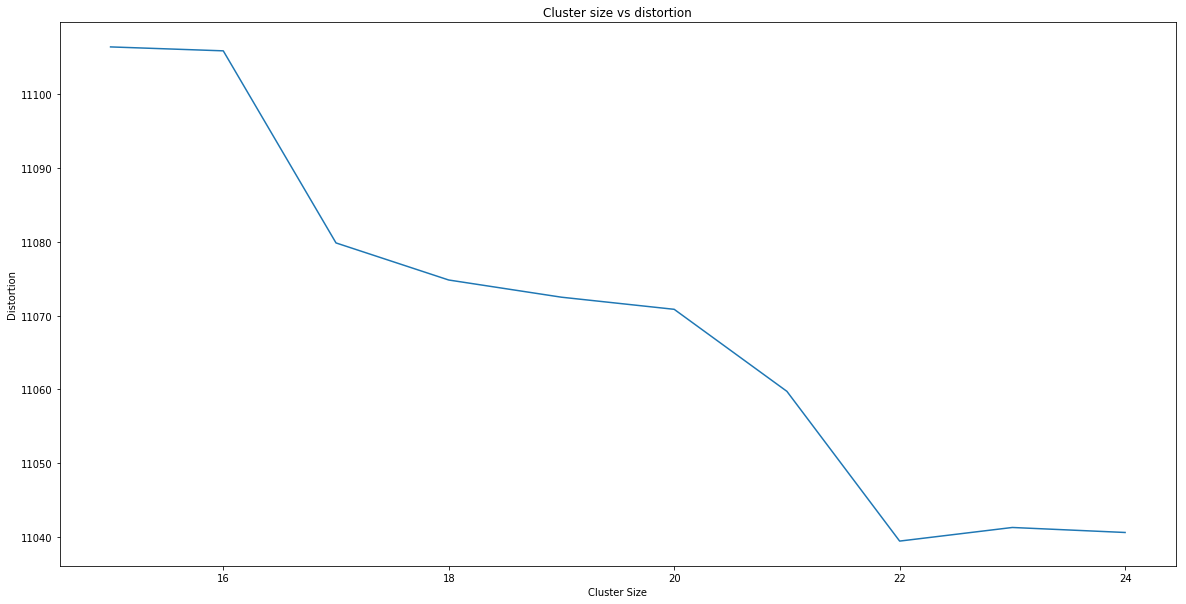

In [17]:
plt.figure(figsize=(20, 10))
plt.title("Cluster size vs distortion")
plt.plot(k, distortionsEuclidian)
plt.xlabel("Cluster Size")
plt.ylabel("Distortion")
plt.show()

By looking at the above graph(elbow) we can say that K = 20 is optimim, has max slope

In [31]:
before = datetime.datetime.now()
kmeans = KmeansOptimized(xTrain, yTrain, euclideanDistanceSKLearn, 20, 100)
after = datetime.datetime.now()

KMeans converged


In [32]:
print("Time taken to train "+str(after - before))

Time taken to train 0:01:56.302393


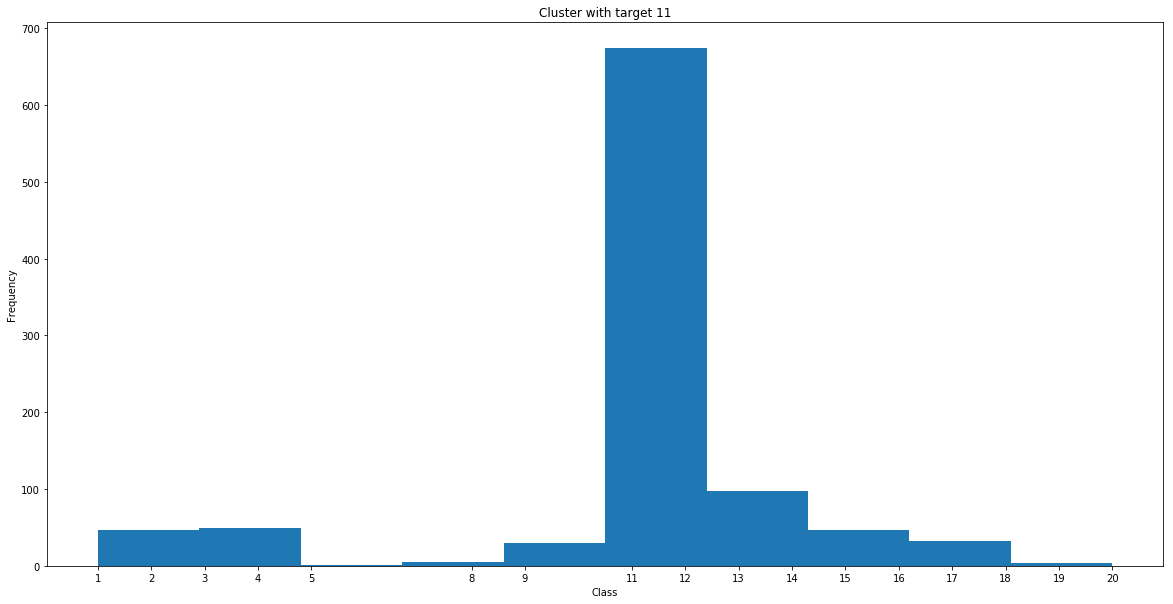

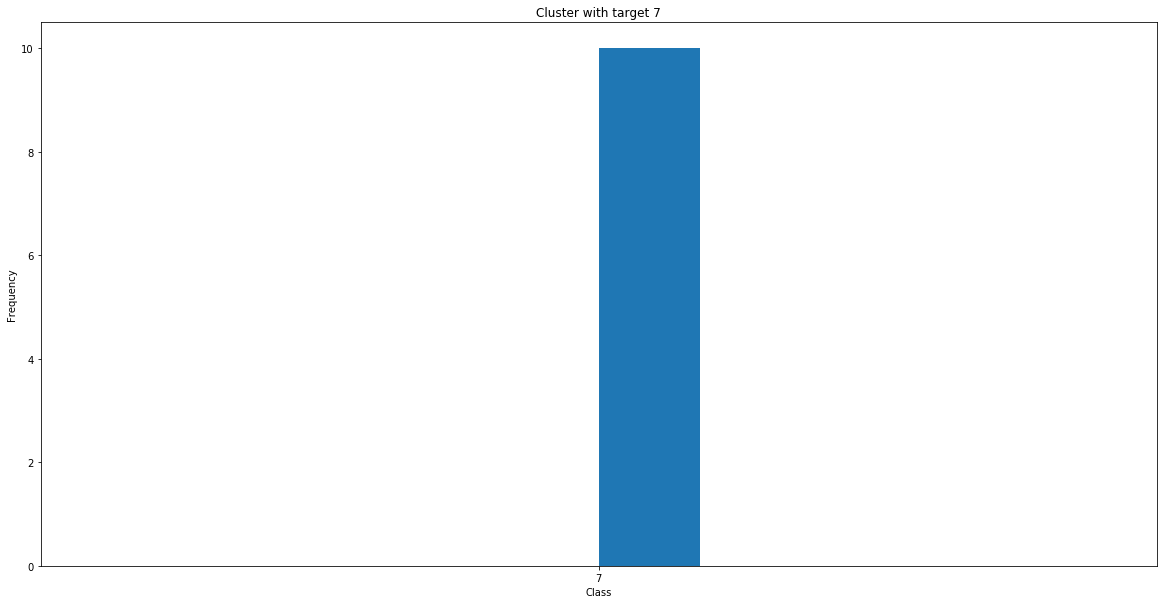

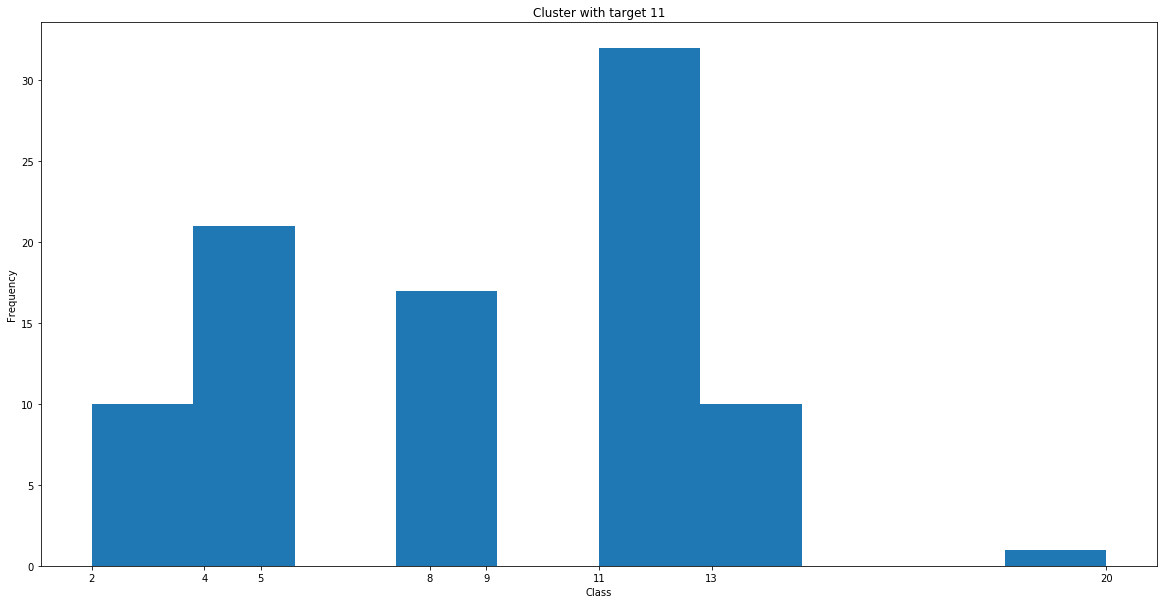

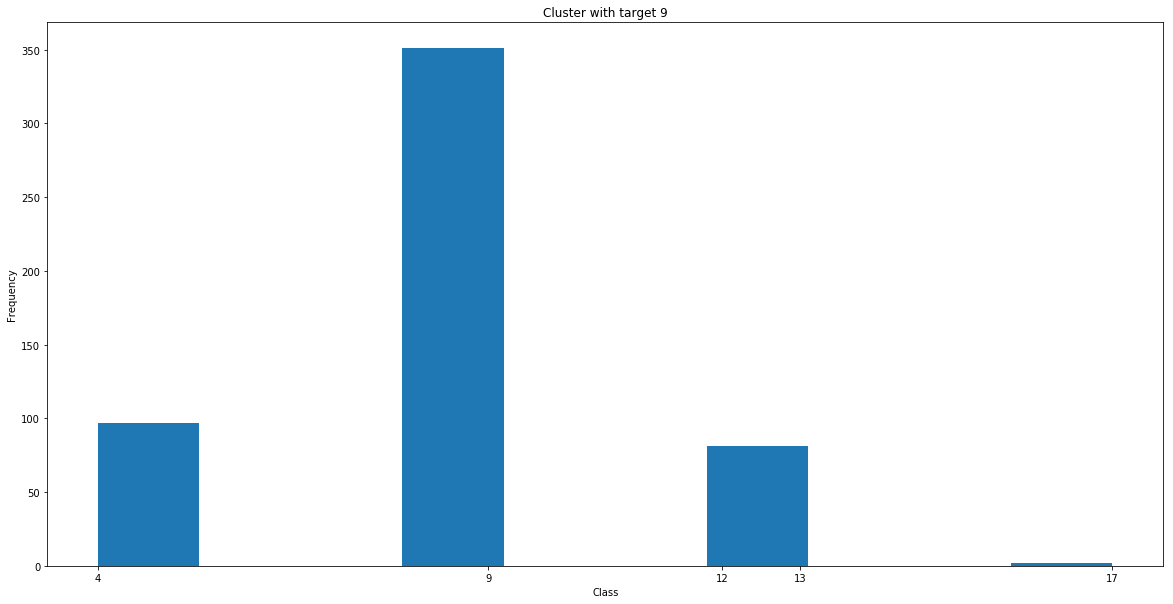

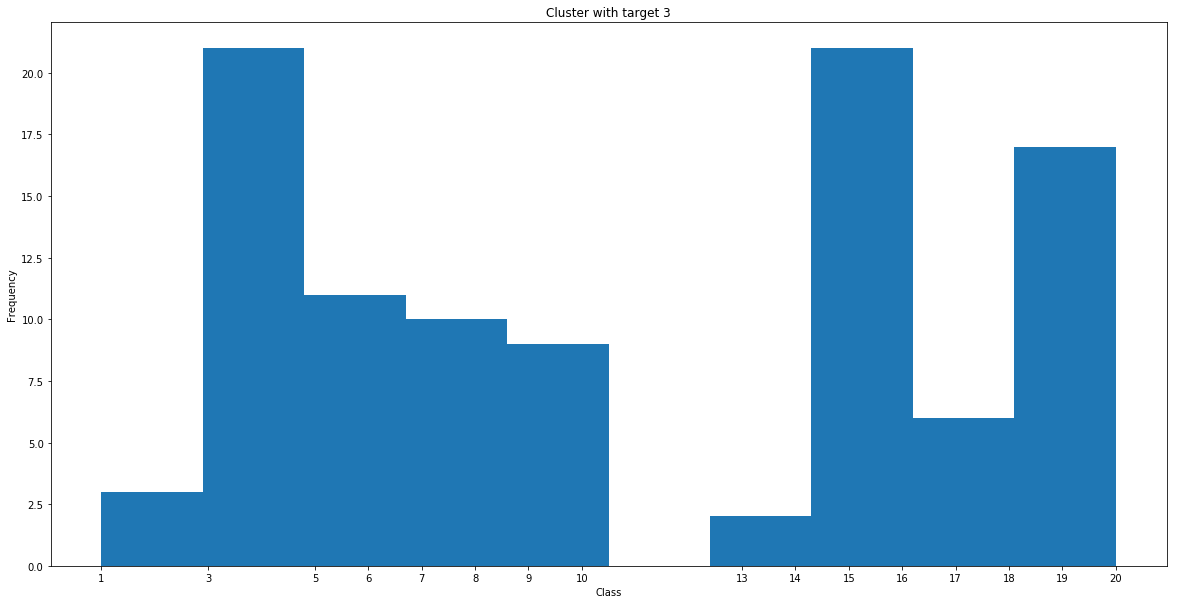

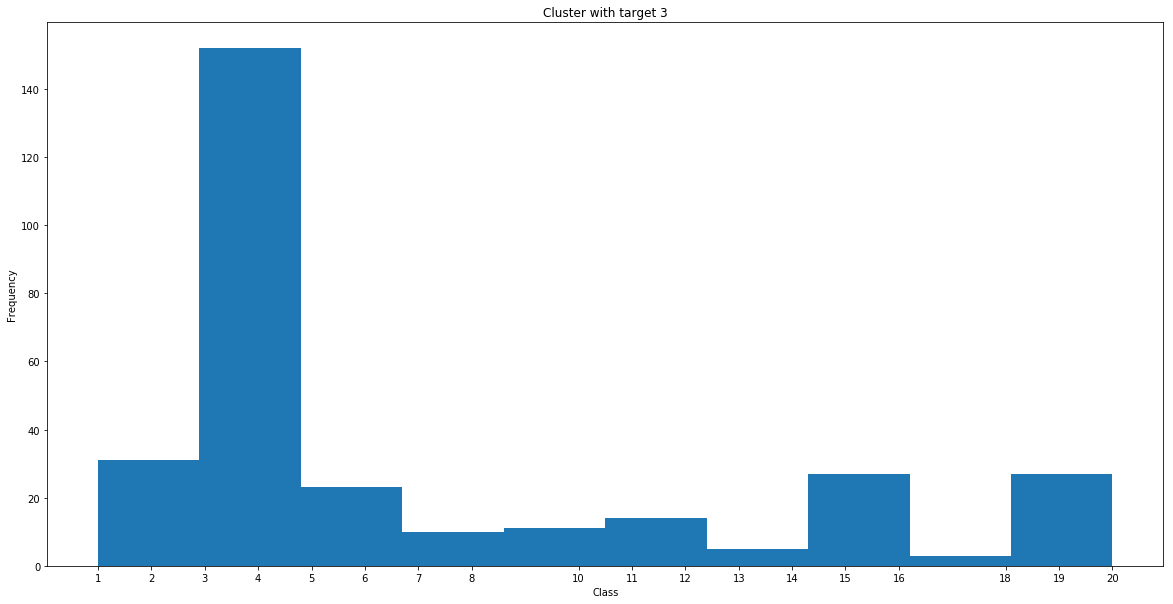

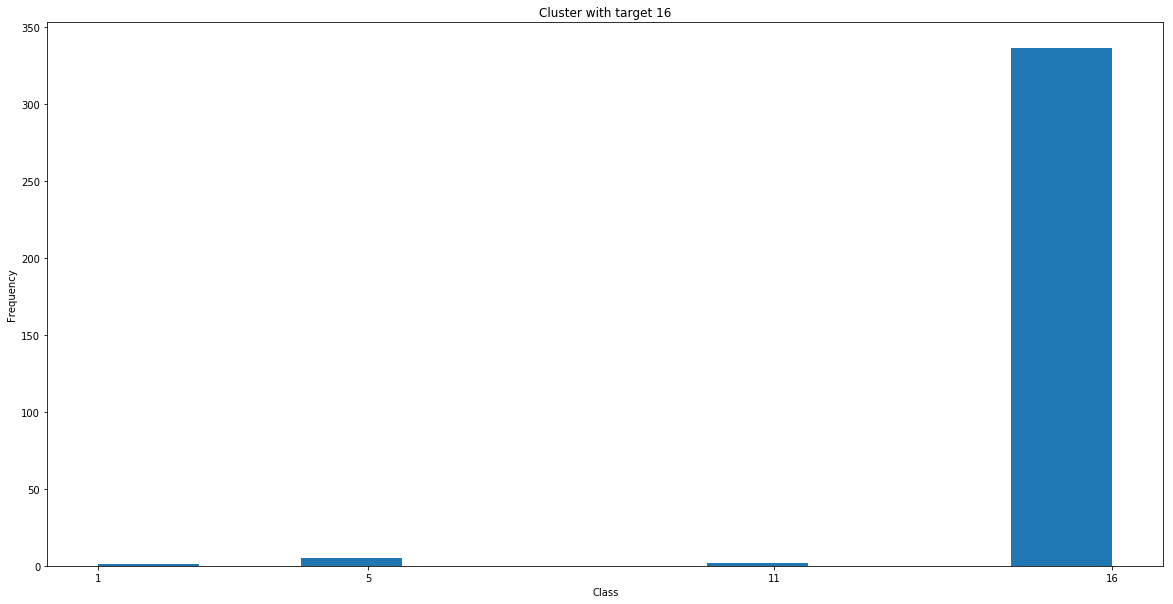

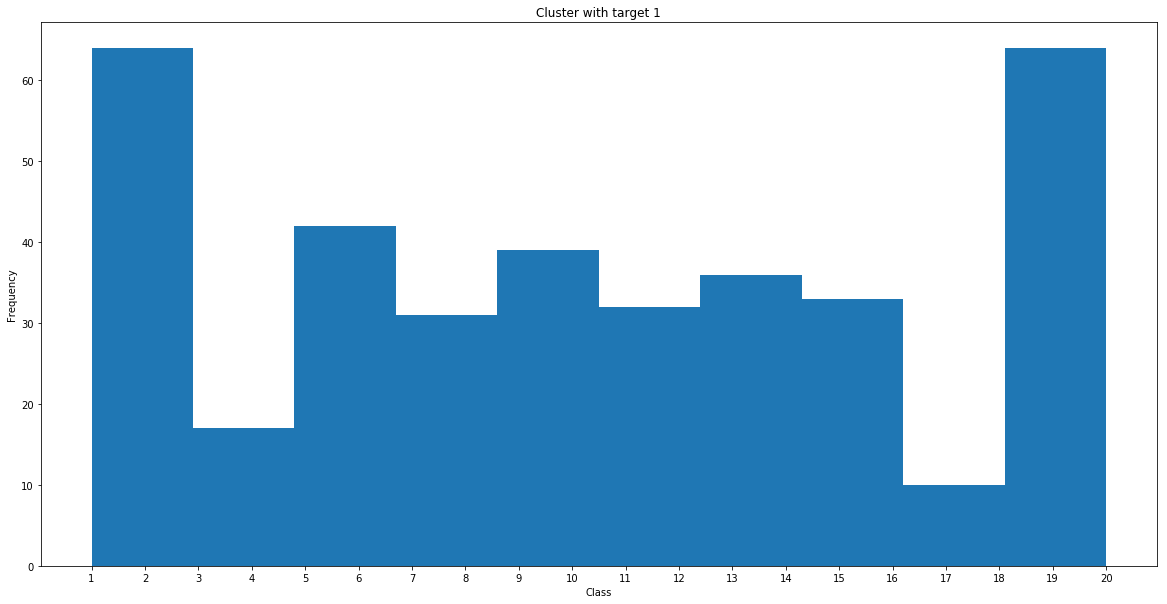

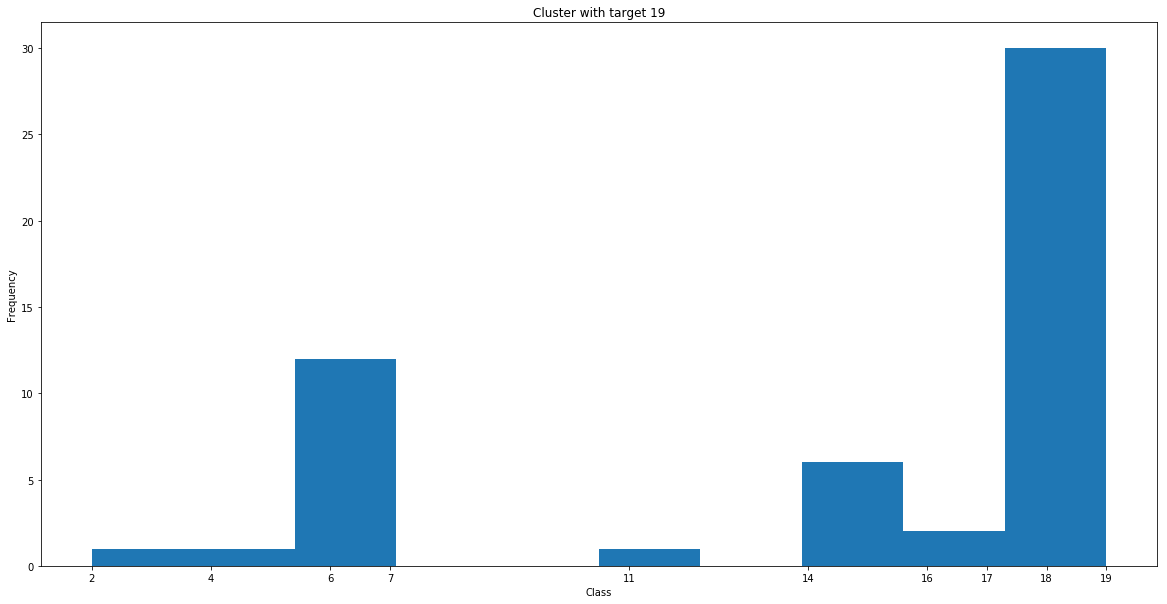

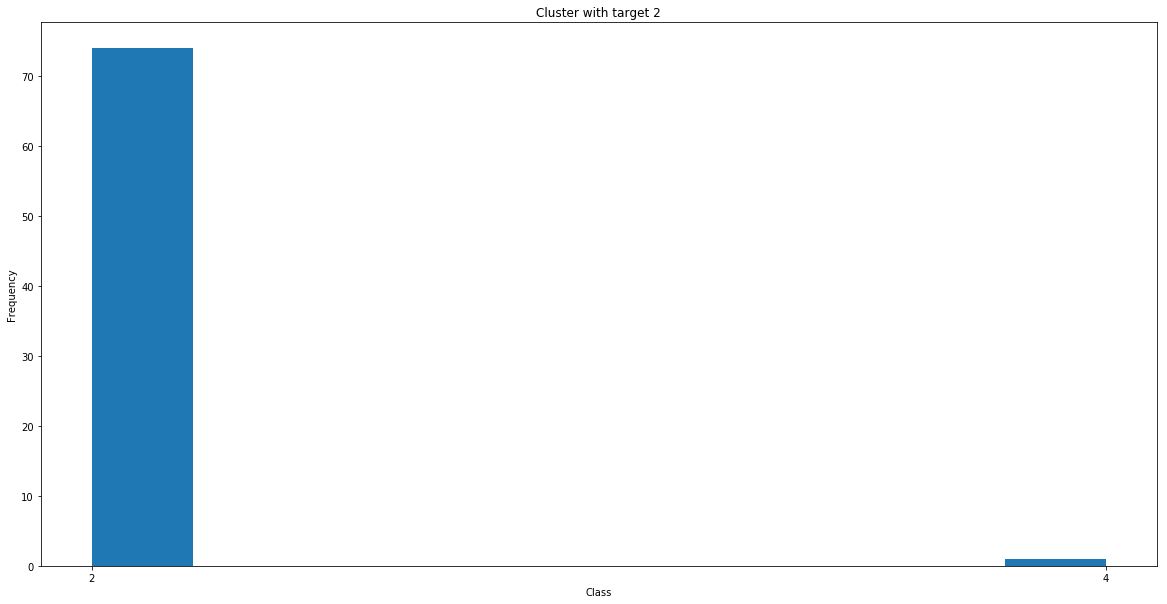

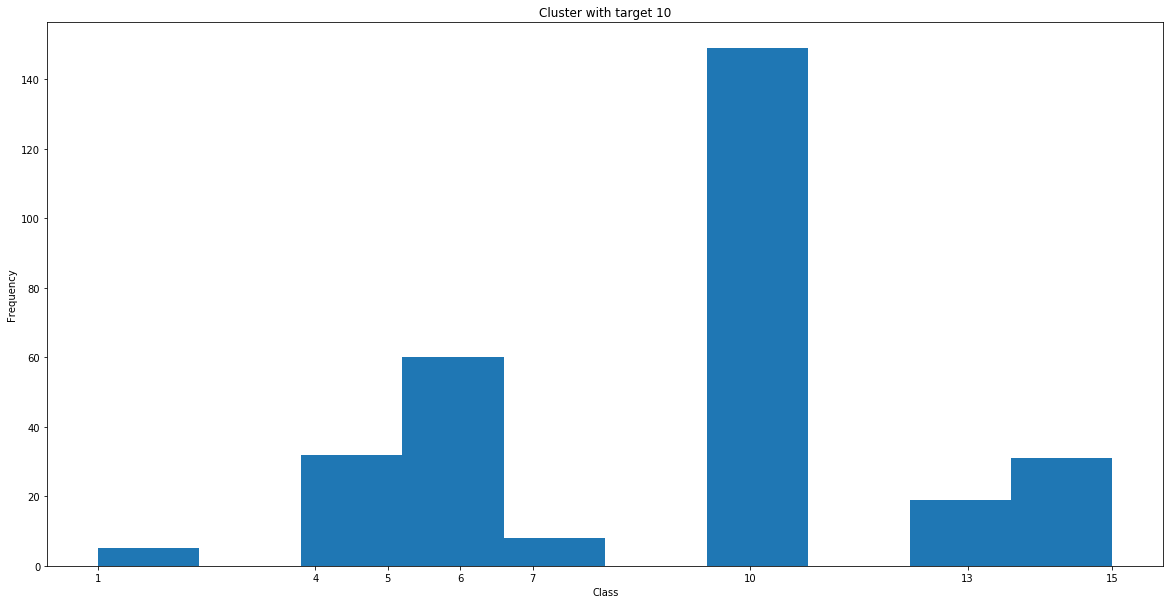

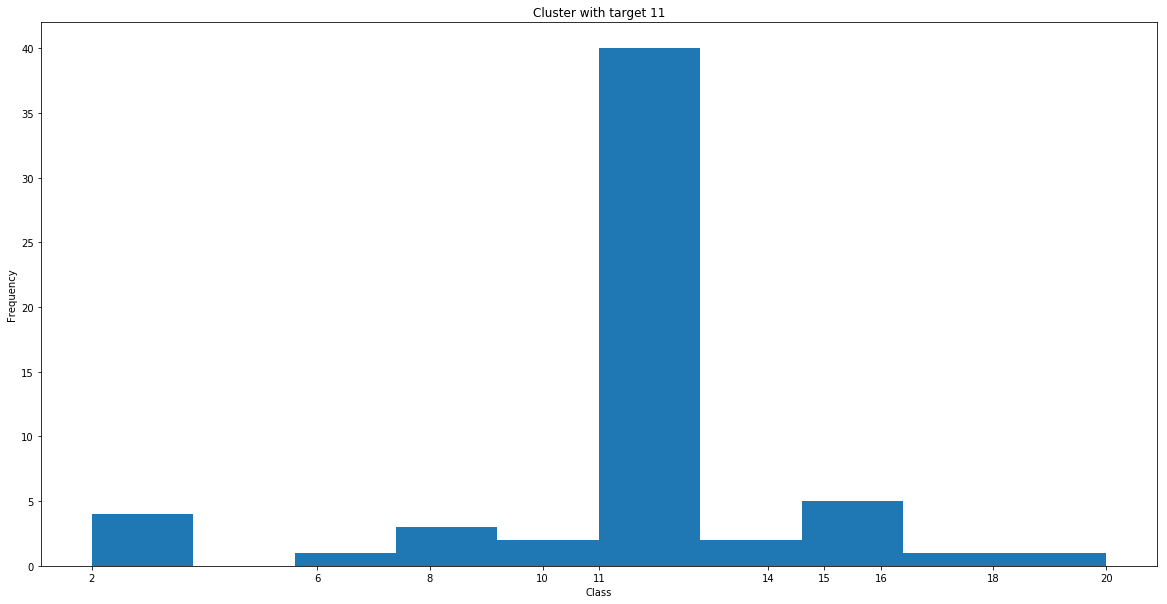

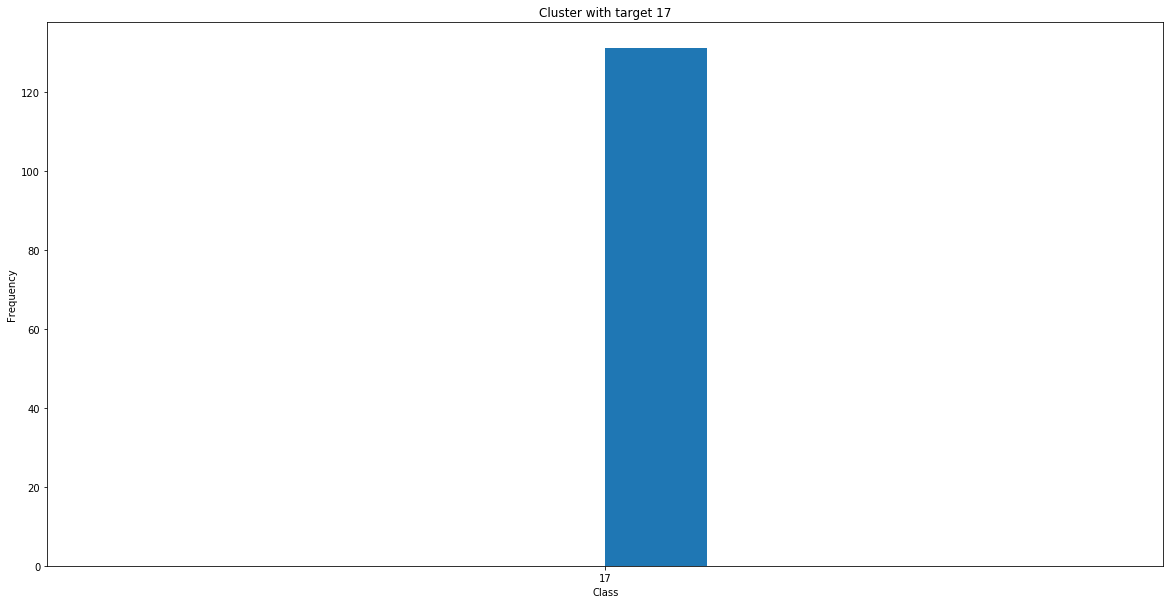

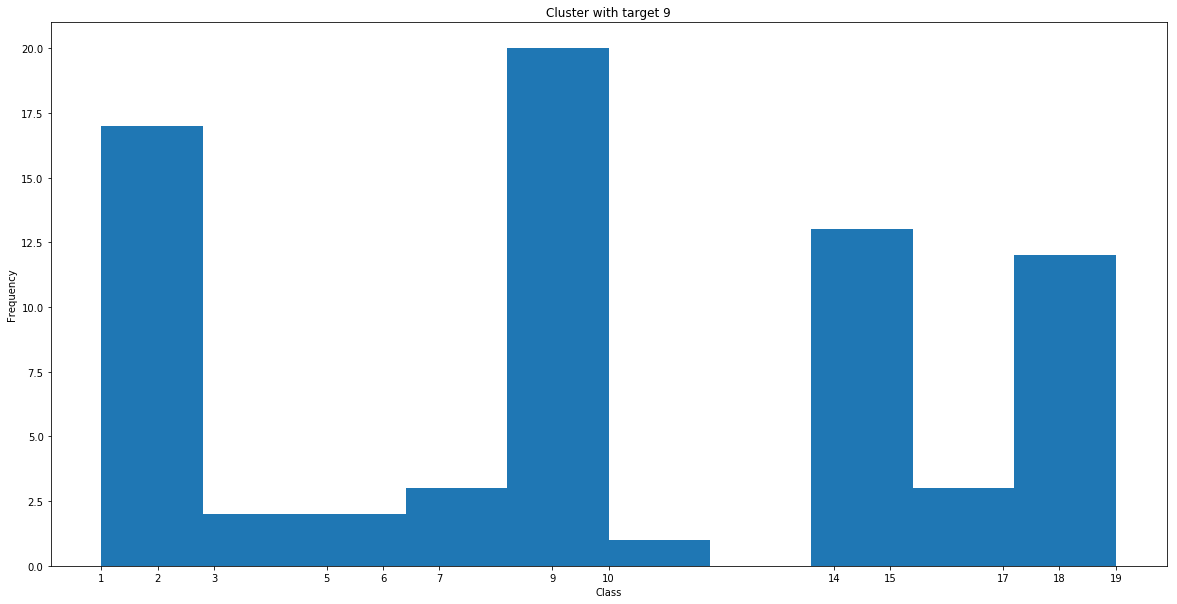

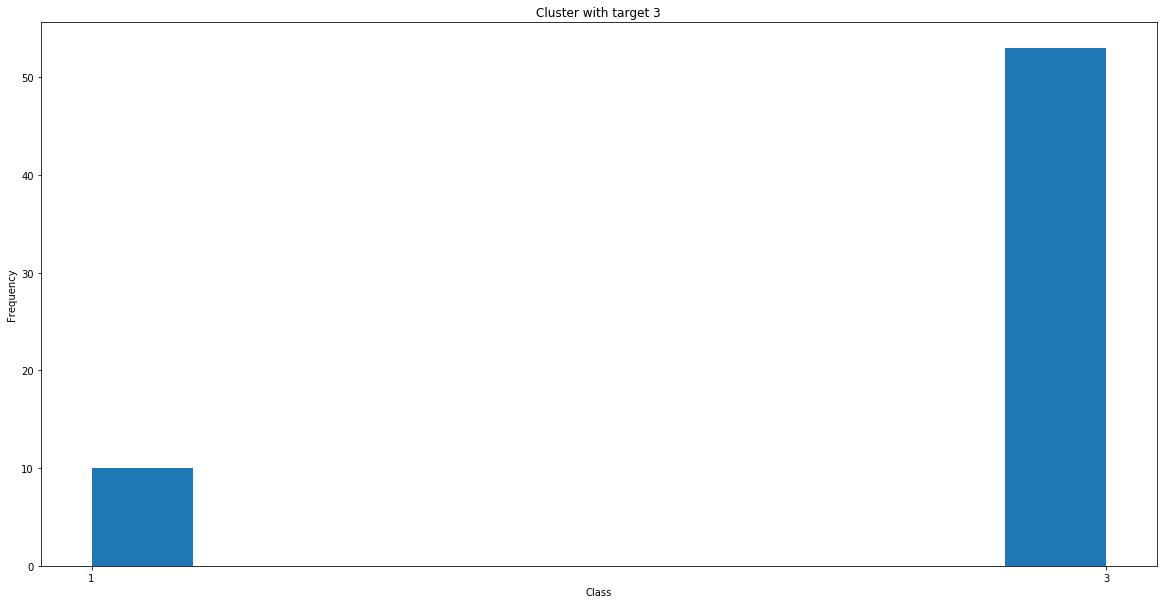

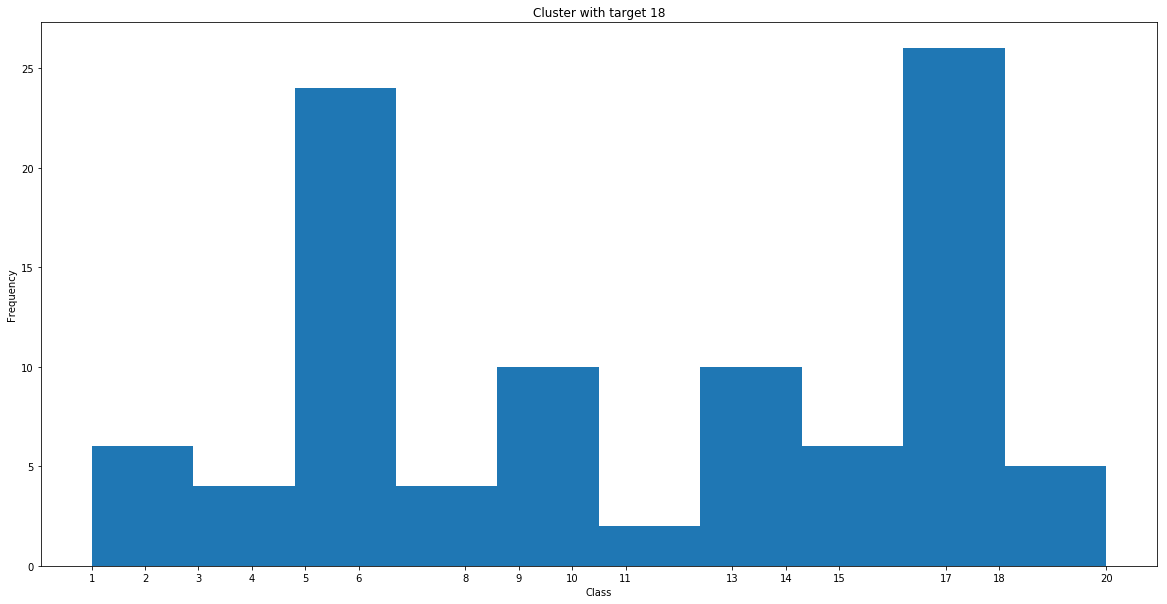

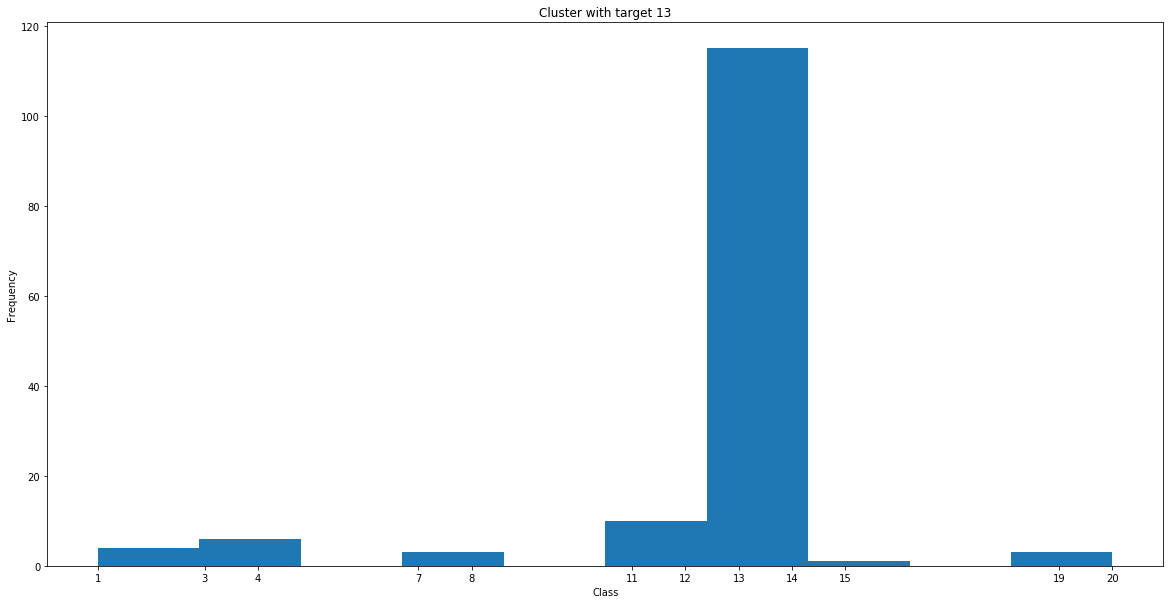

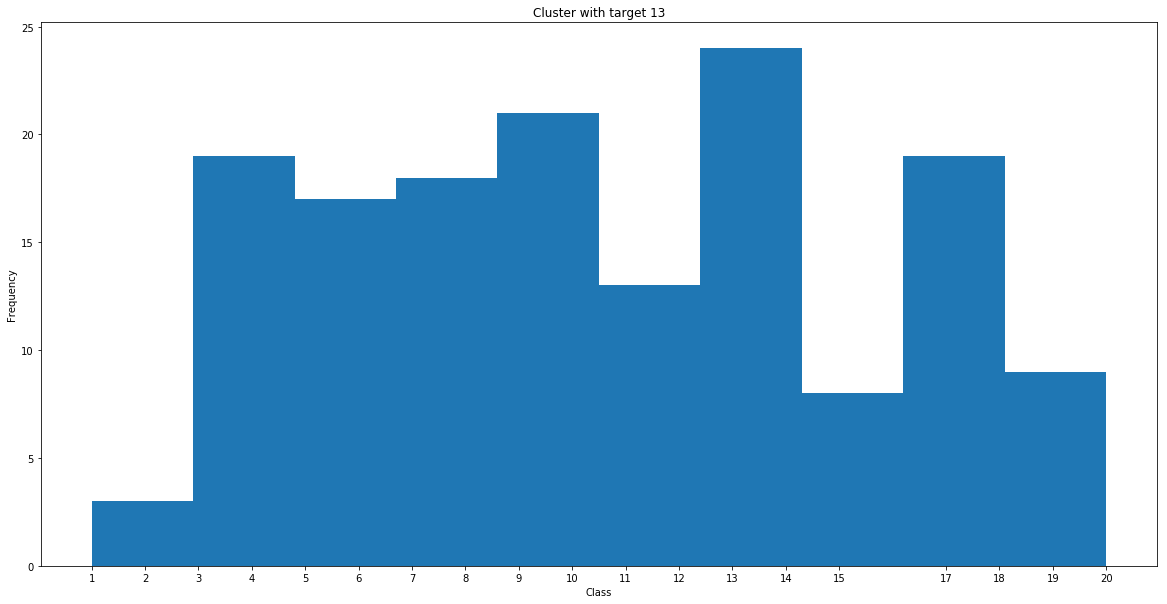

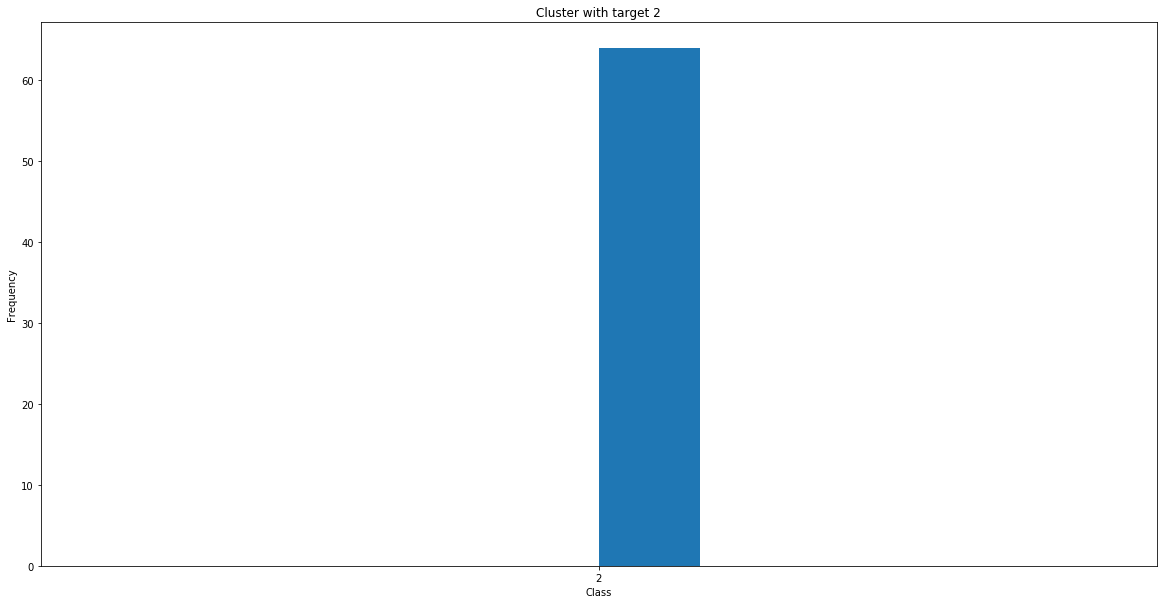

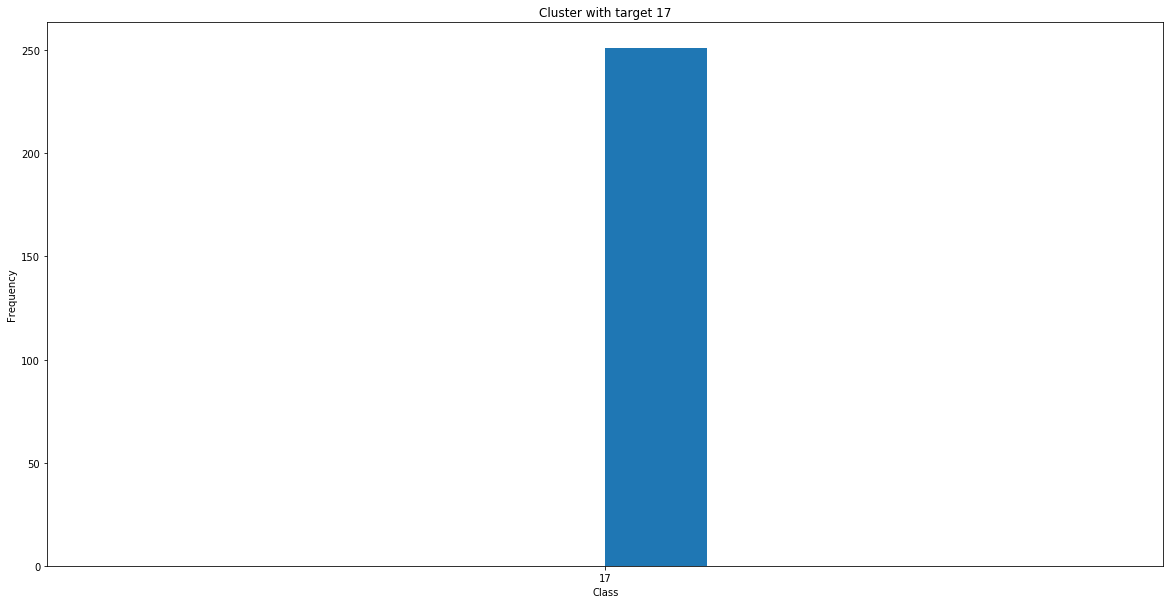

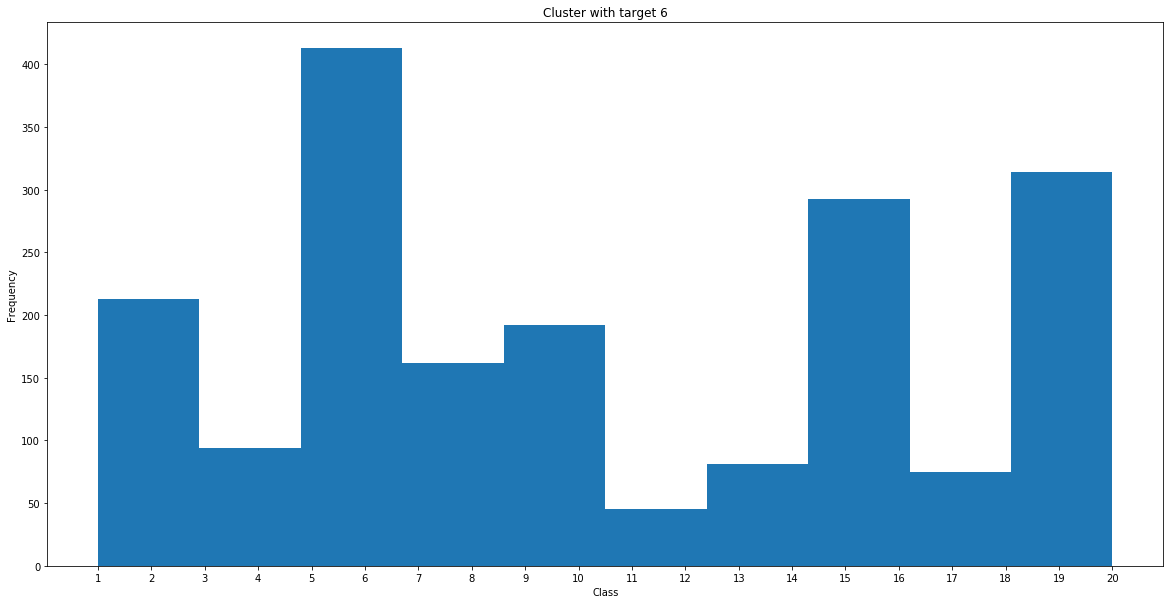

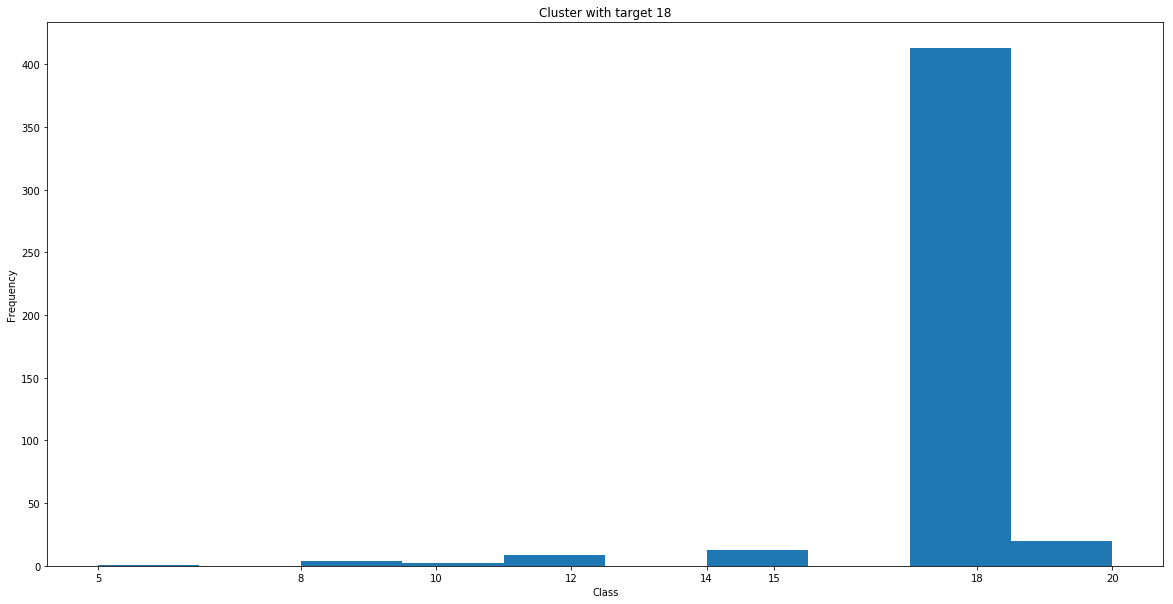

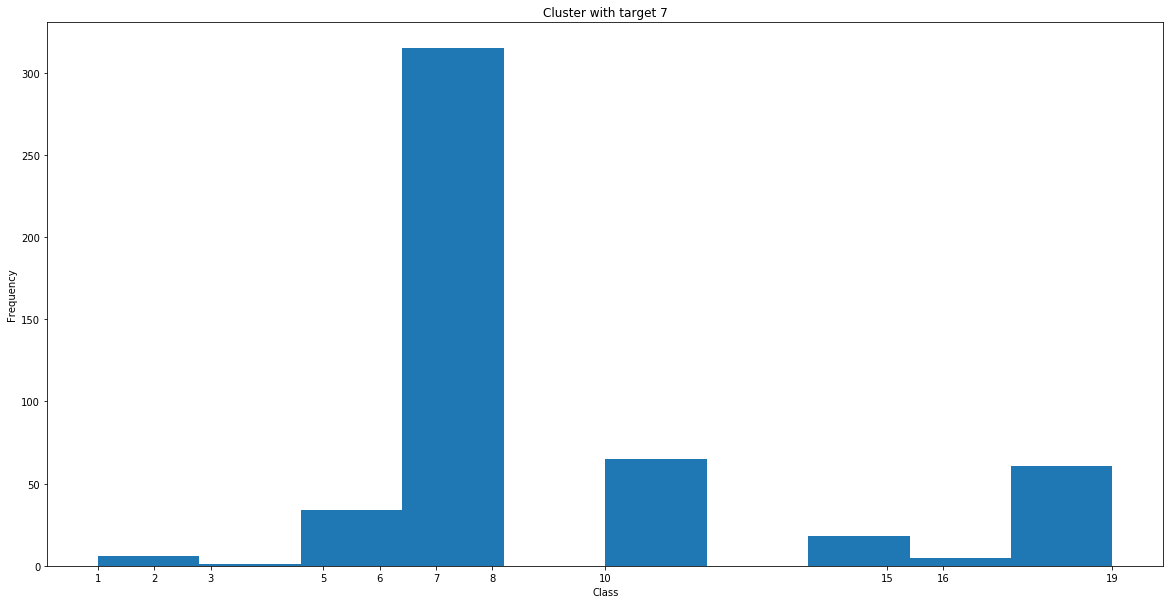

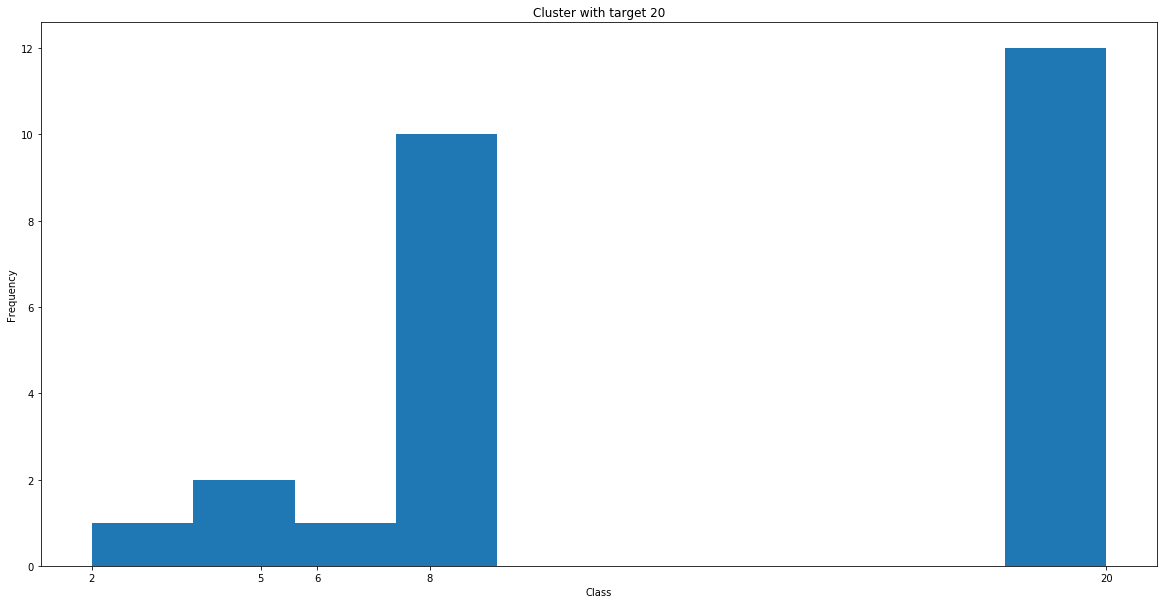

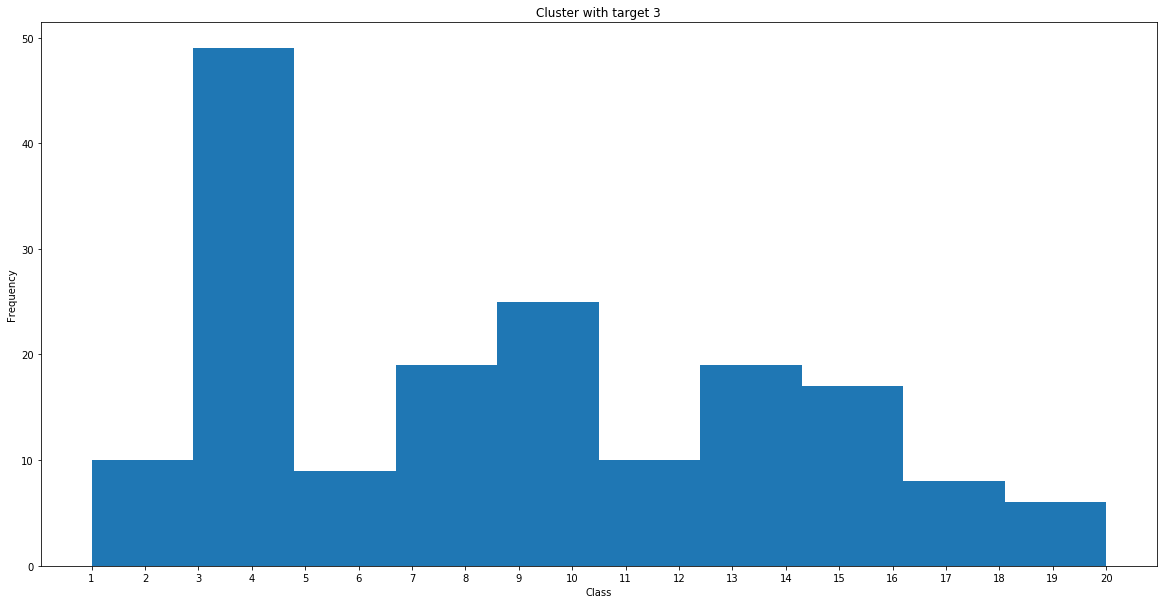

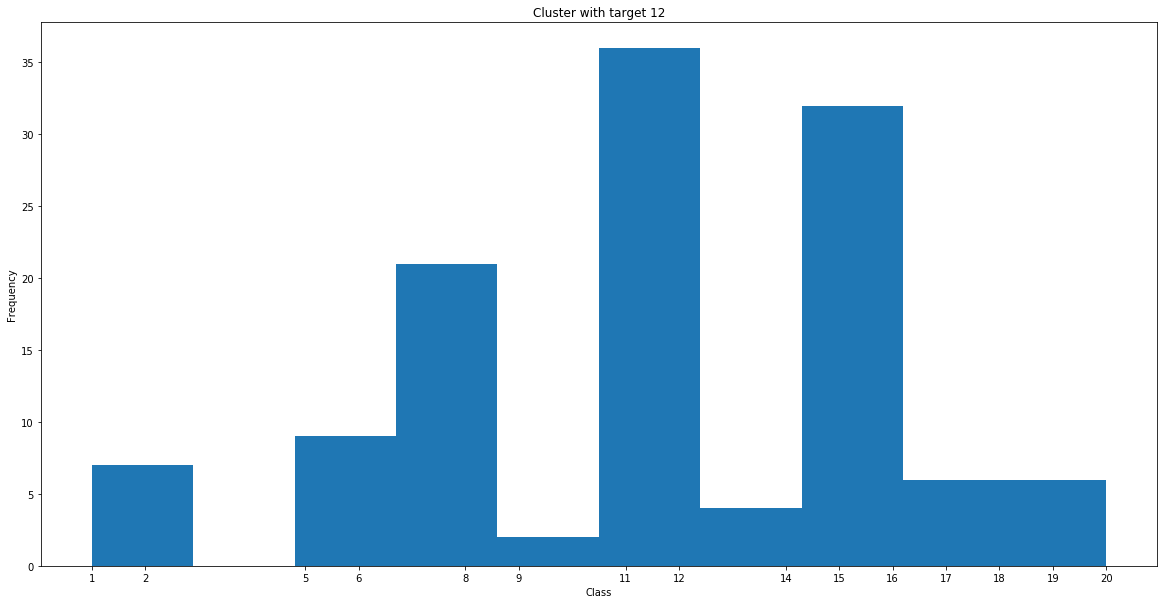

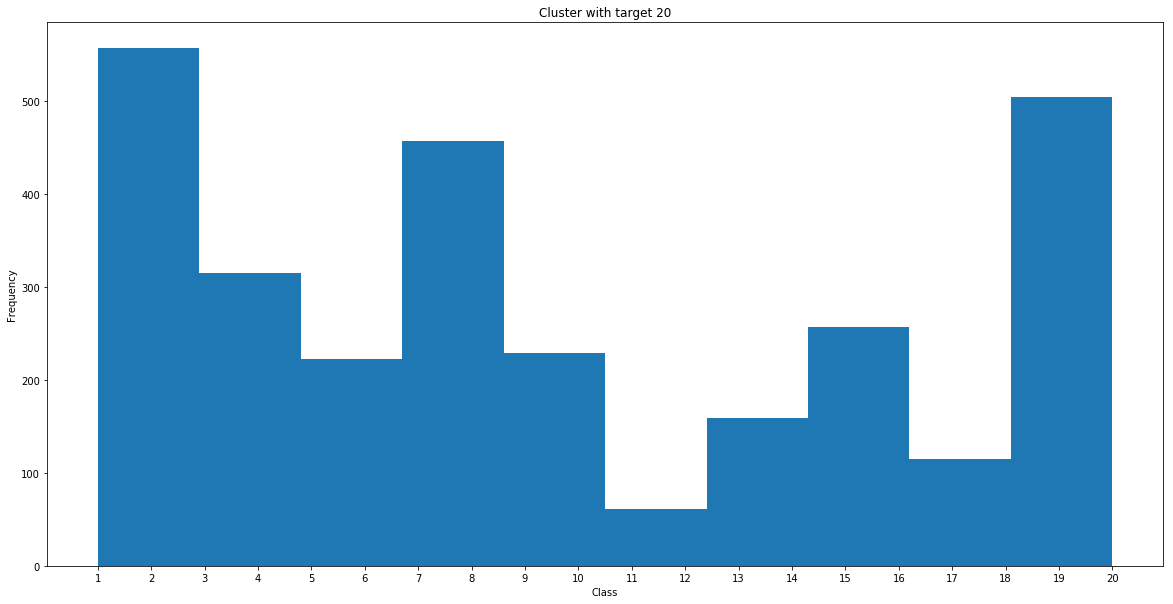

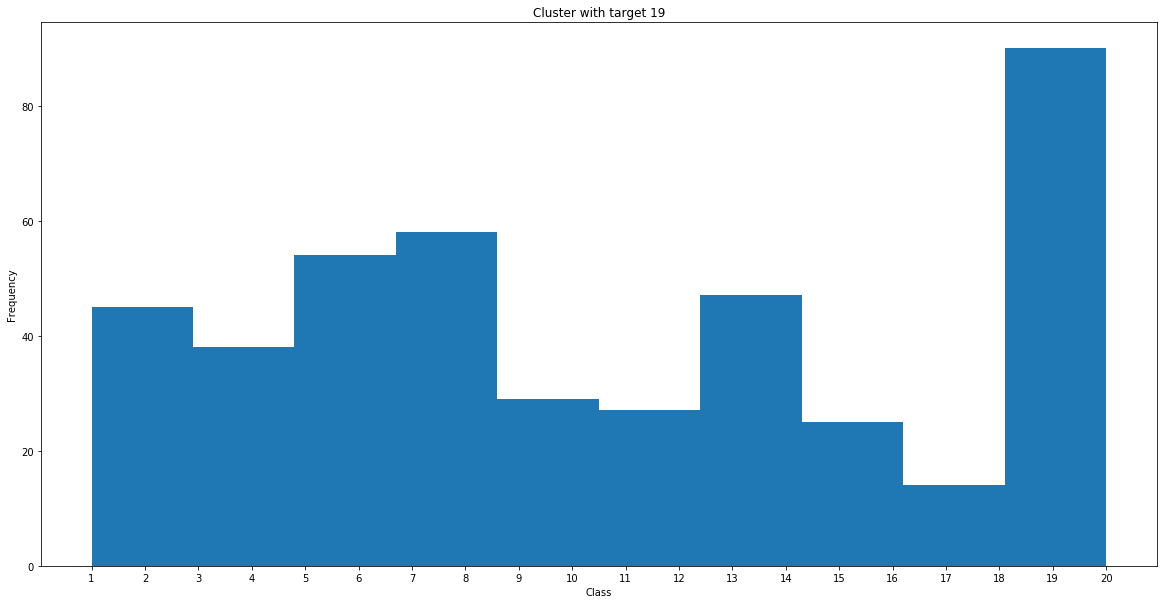

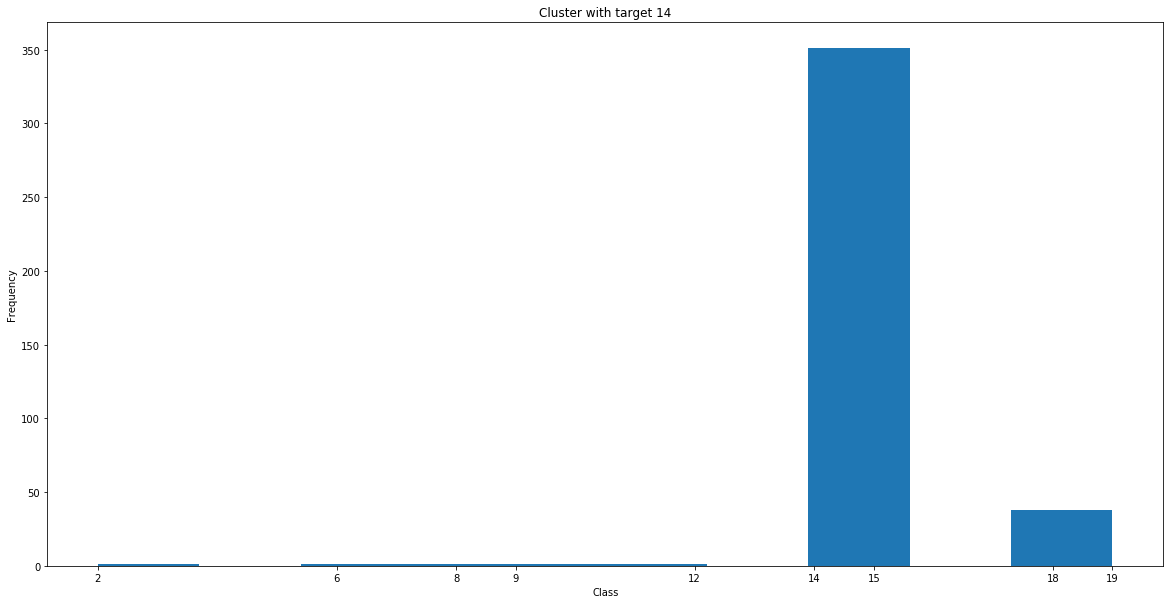

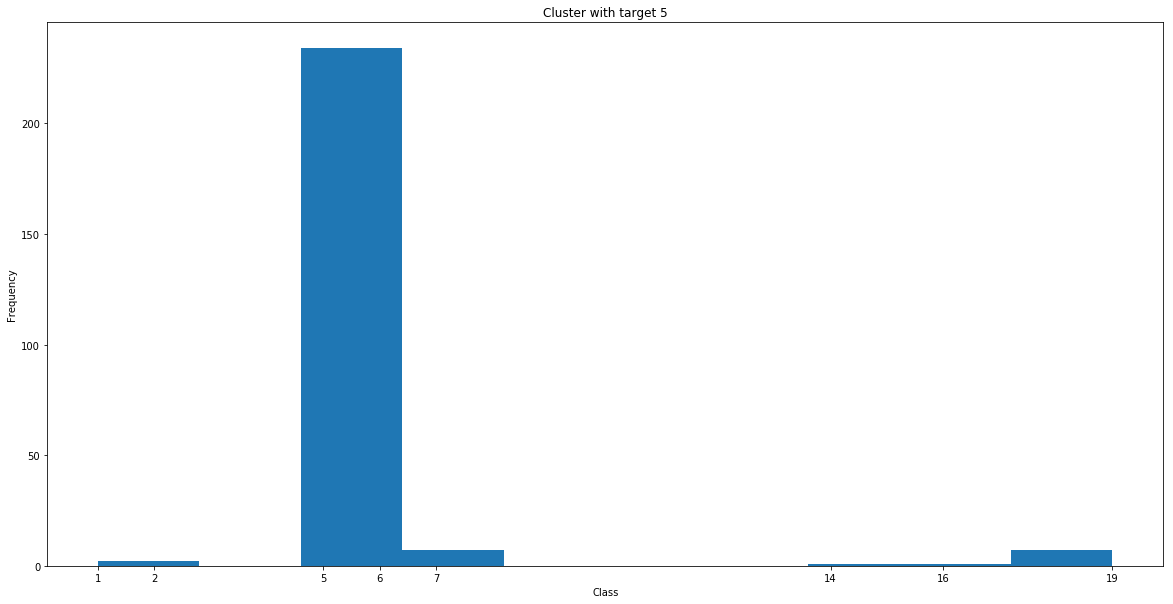

In [33]:
kmeans.plotClusterQuality()

## F1 score

In [34]:
yPrediction = kmeans.predict(xTest)
print(classification_report(yTest, yPrediction, target_names=lookupDict))

                          precision    recall  f1-score   support

         sci.electronics       0.06      0.04      0.05       393
      talk.politics.misc       0.90      0.02      0.04       396
                 sci.med       0.40      0.36      0.38       394
           comp.graphics       0.00      0.00      0.00       251
               sci.space       0.92      0.25      0.39       395
      talk.religion.misc       0.14      0.53      0.22       385
          comp.windows.x       0.63      0.54      0.58       394
 comp.os.ms-windows.misc       0.00      0.00      0.00       396
               rec.autos       0.62      0.53      0.57       398
  soc.religion.christian       0.39      0.19      0.26       392
comp.sys.ibm.pc.hardware       0.35      0.63      0.45       364
      talk.politics.guns       0.08      0.02      0.03       310
      rec.sport.baseball       0.29      0.13      0.18       319
             alt.atheism       0.89      0.48      0.62       397
         

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


The performanace of the kmeans using euclidian distance with ground truth is very bad. 

# Using euclidian distance and Cosine Similarity

In [37]:
k = range(15, 25)
distortionsCosine = []

for i in k:
    kmeans = KmeansOptimized(xTrain, yTrain, cosineDistanceSKLearn, i, 100)
    print(kmeans.distortion)
    distortionsCosine.append(kmeans.distortion)
    time.sleep(0.5)

KMeans converged
11139.841994574212
KMeans converged
11134.232851850162
KMeans converged
11125.749005091224
KMeans converged
11114.861749877207
KMeans converged
11098.839174768184
KMeans converged
11113.191933828833
KMeans converged
11100.423914966166
KMeans converged
11088.657552575467
KMeans converged
11093.658585447925
KMeans converged
11066.852515904115


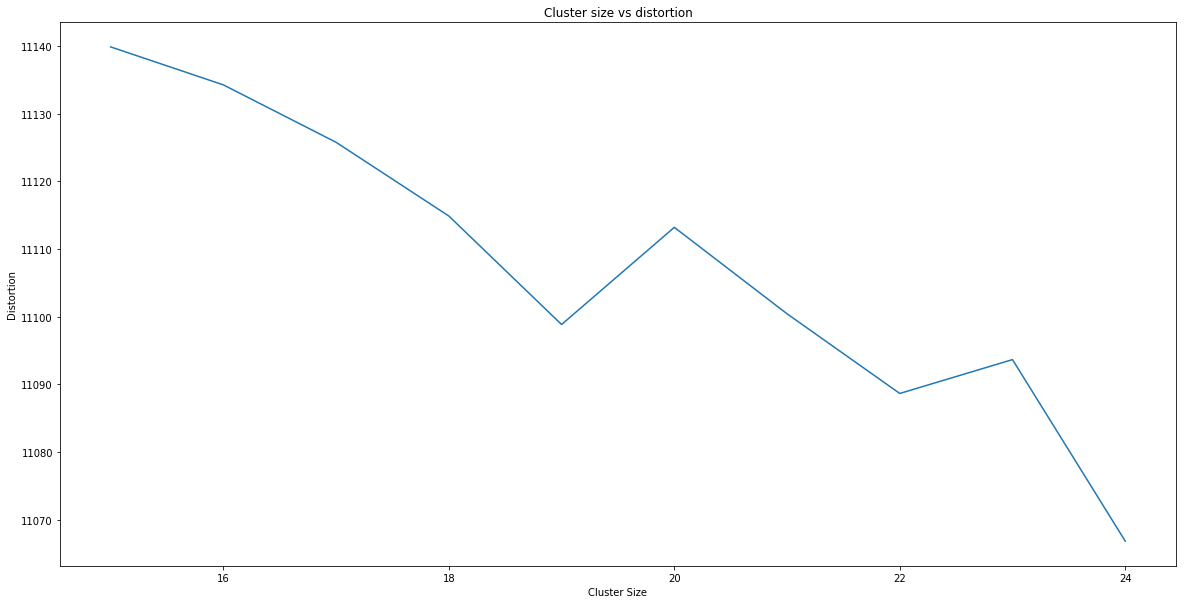

In [38]:
plt.figure(figsize=(20, 10))
plt.title("Cluster size vs distortion")
plt.plot(k, distortionsCosine)
plt.xlabel("Cluster Size")
plt.ylabel("Distortion")
plt.show()

In [39]:
before = datetime.datetime.now()
kmeans = KmeansOptimized(xTrain, yTrain, cosineDistanceSKLearn, 20, 100)
after = datetime.datetime.now()

KMeans converged


In [40]:
print("Time taken to train "+str(after - before))

Time taken to train 0:02:16.728921


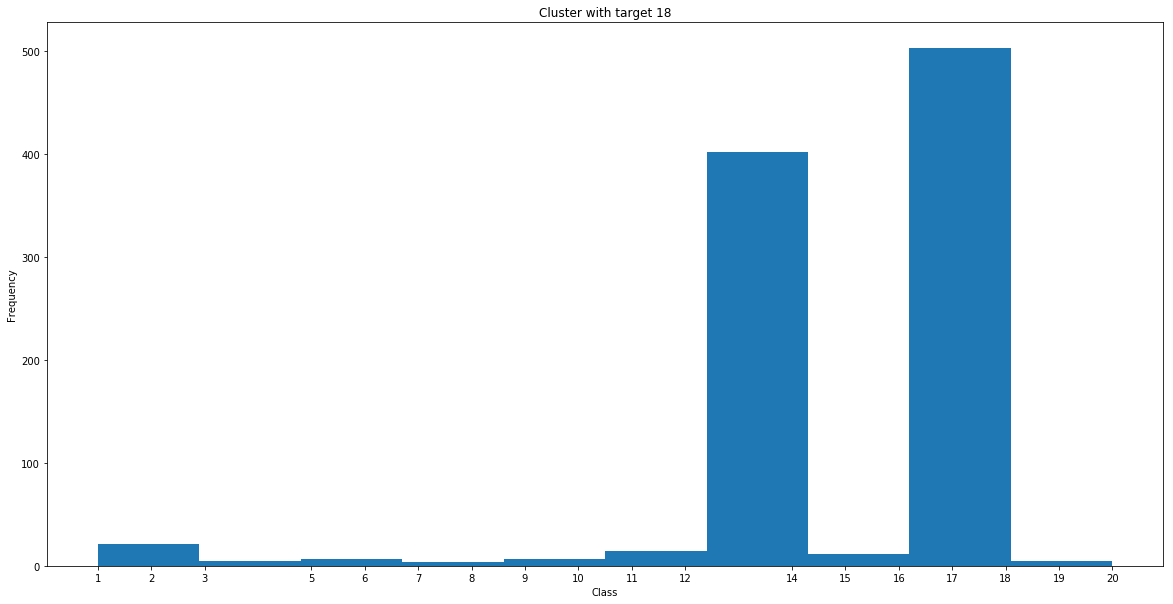

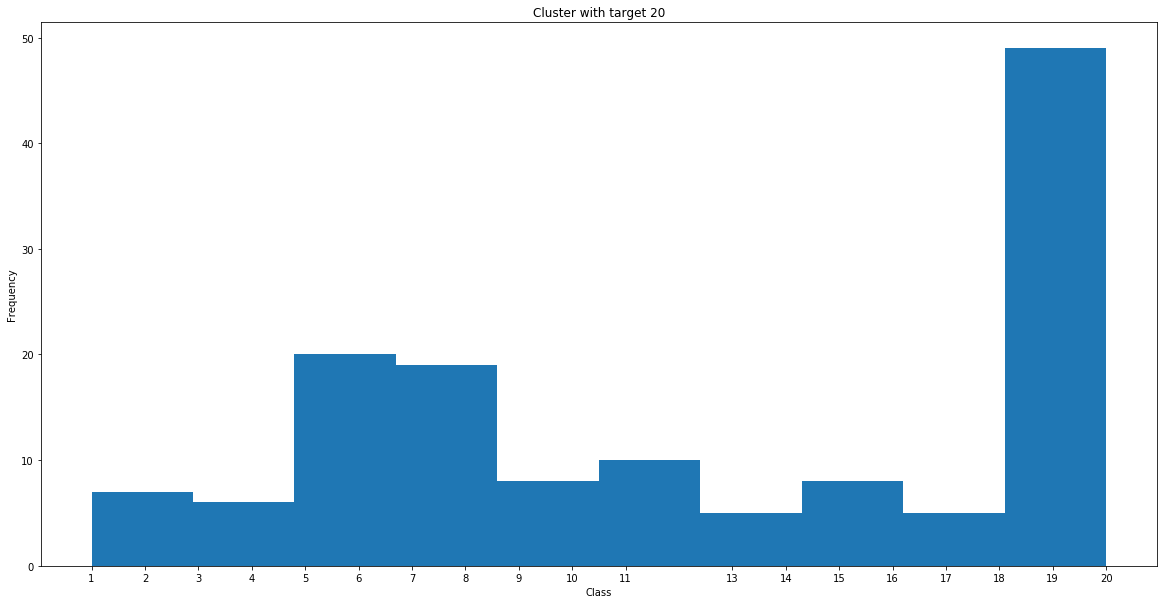

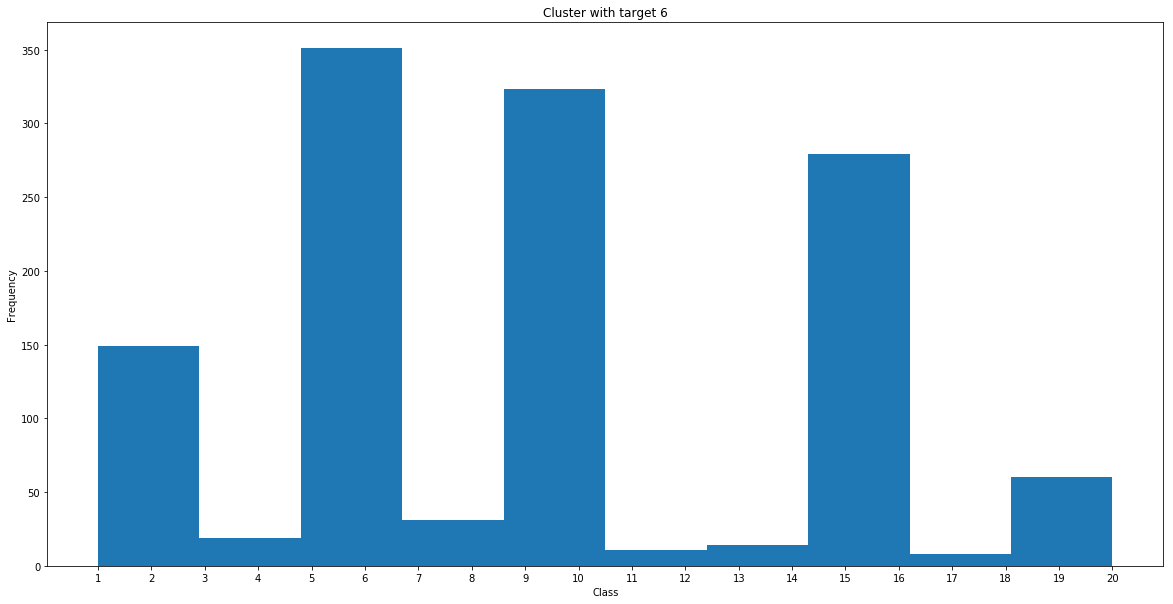

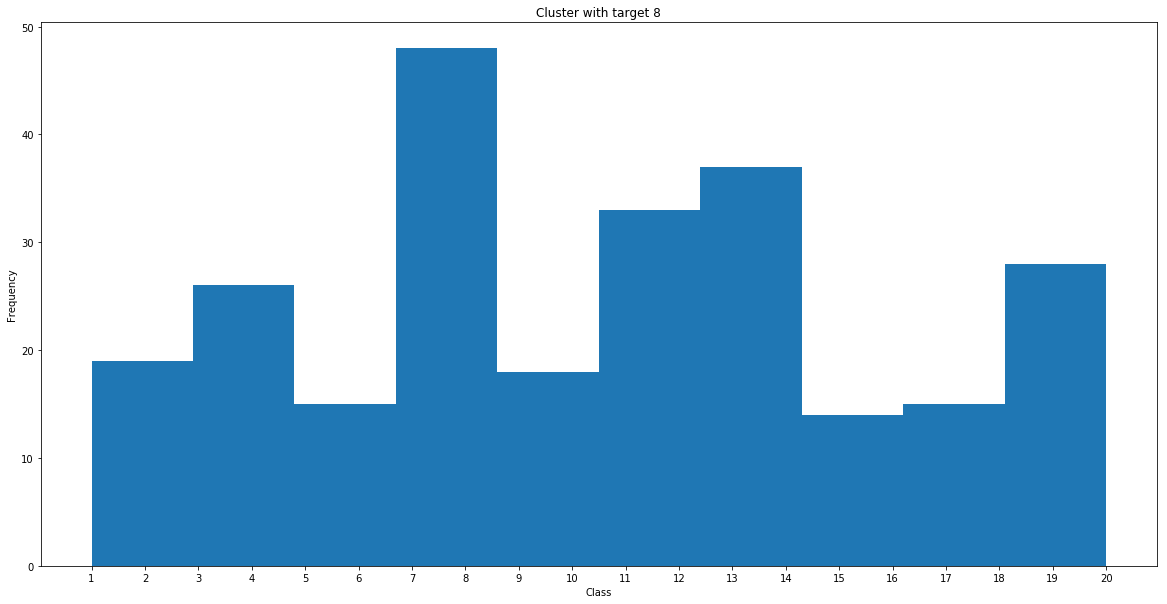

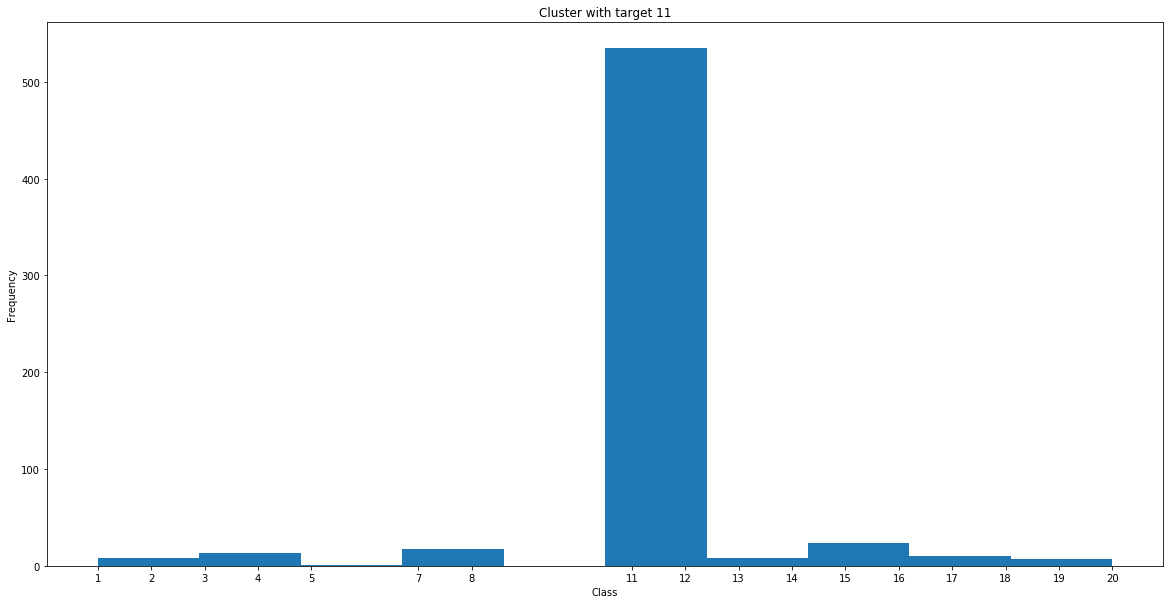

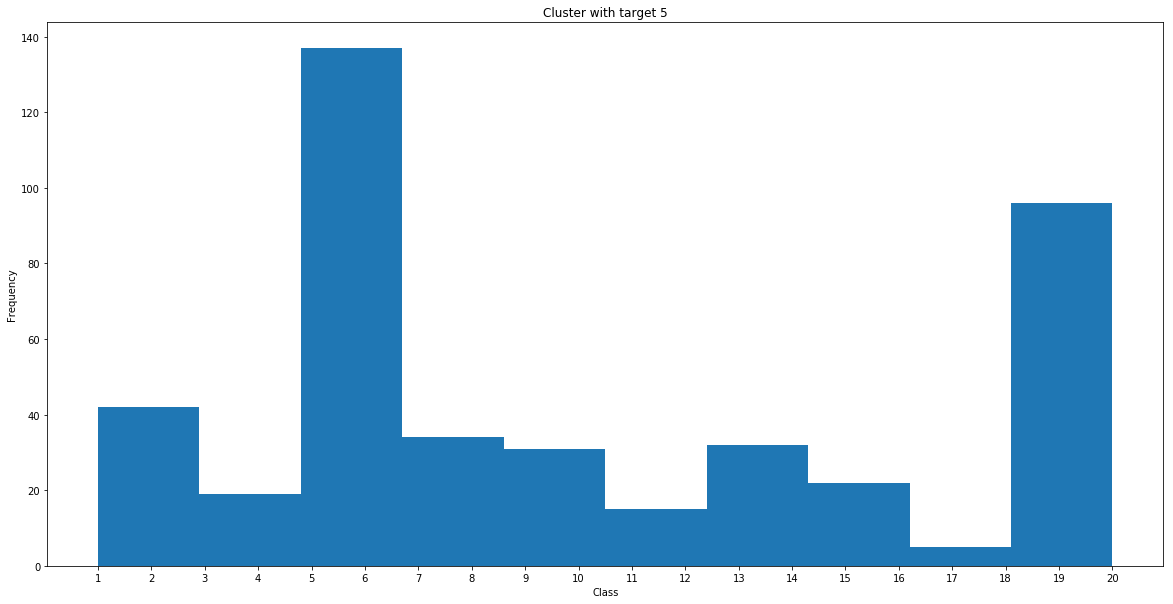

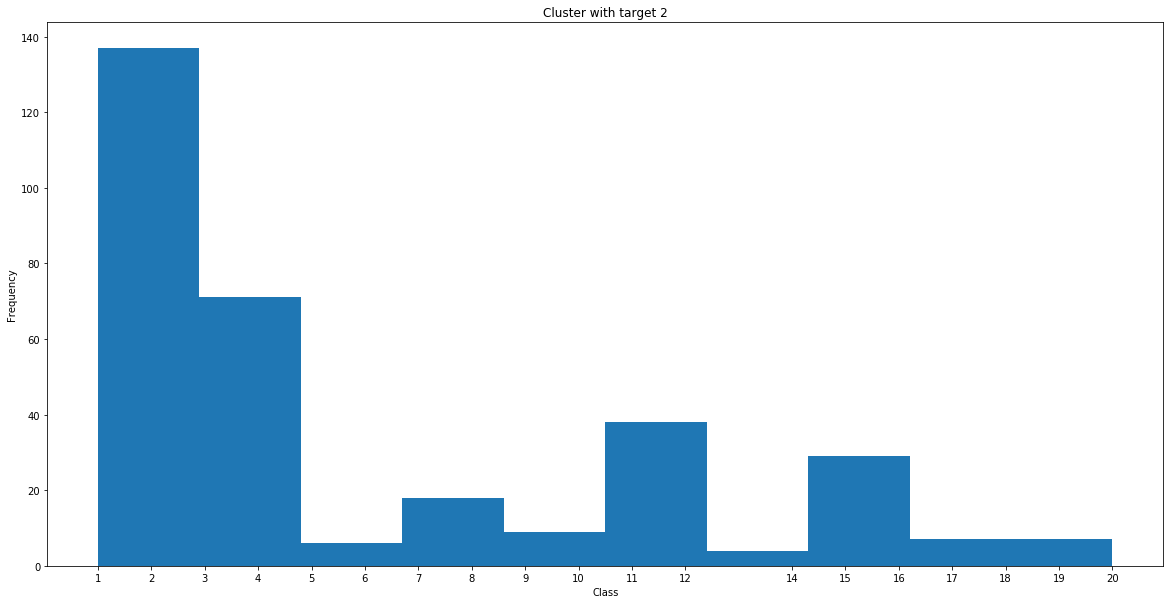

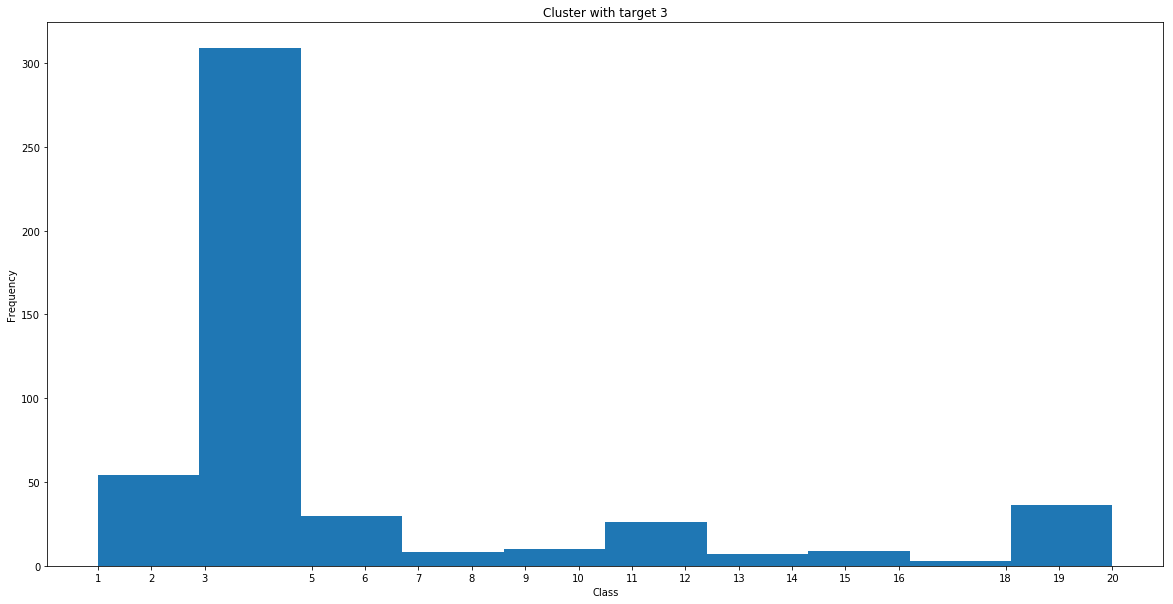

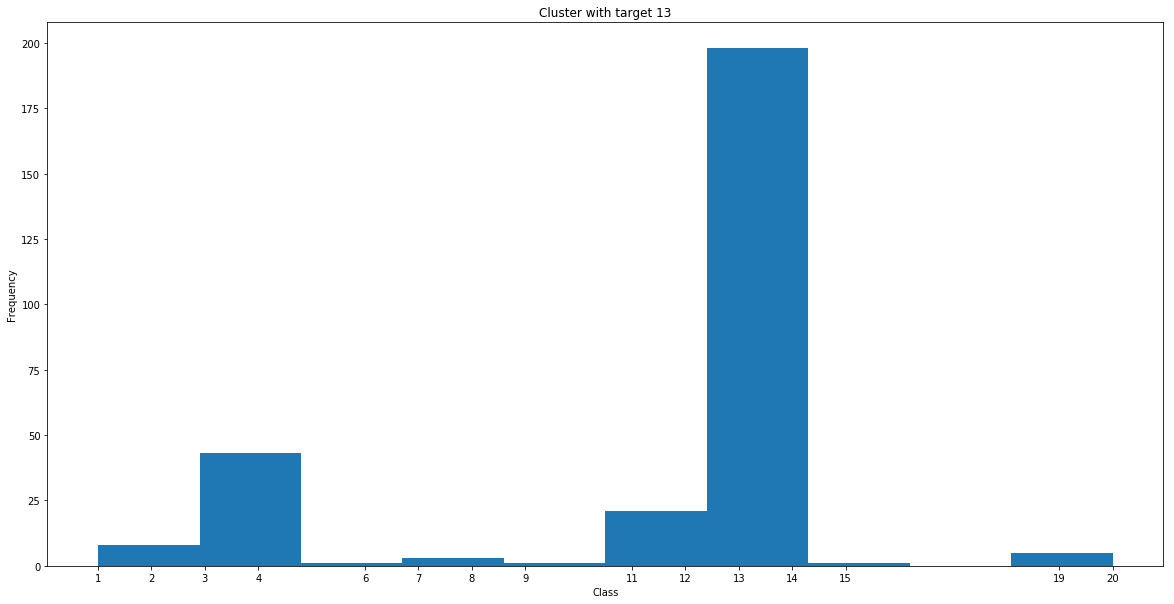

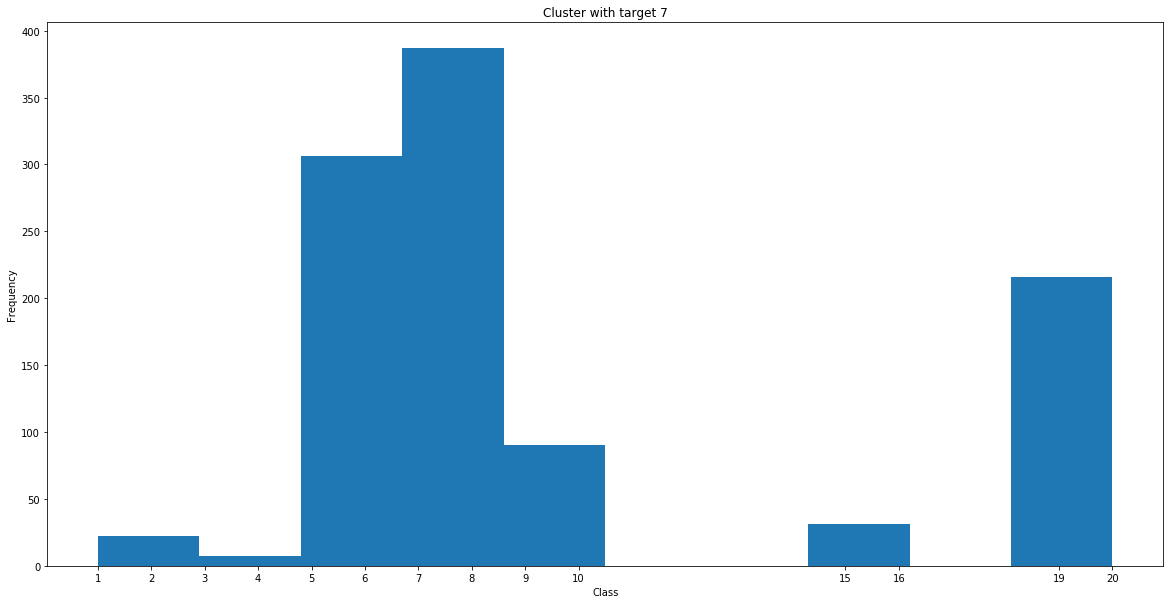

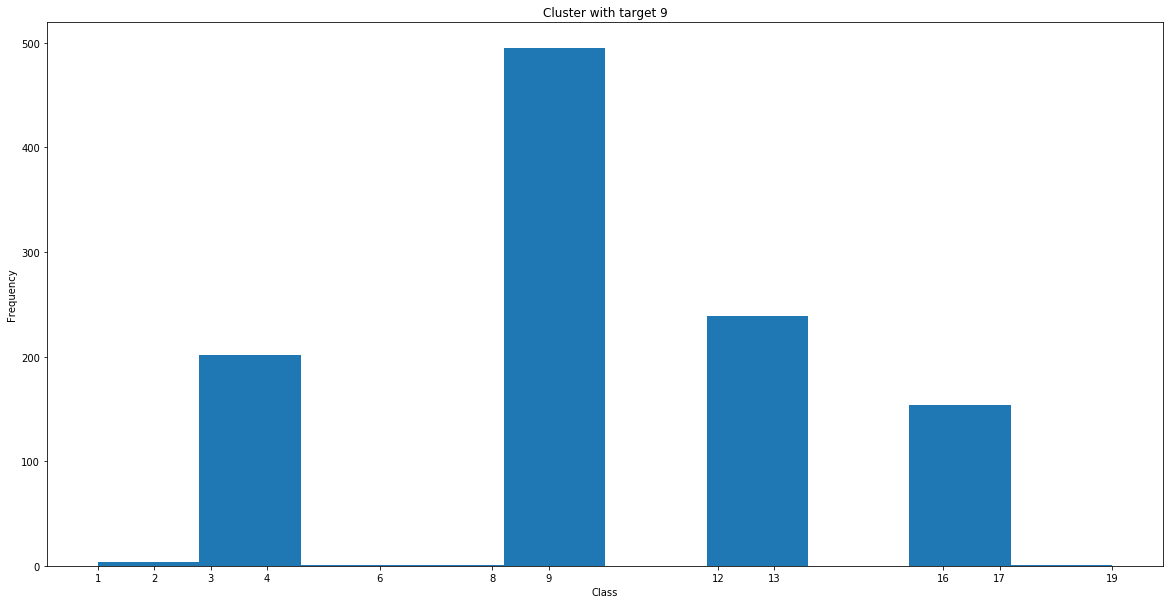

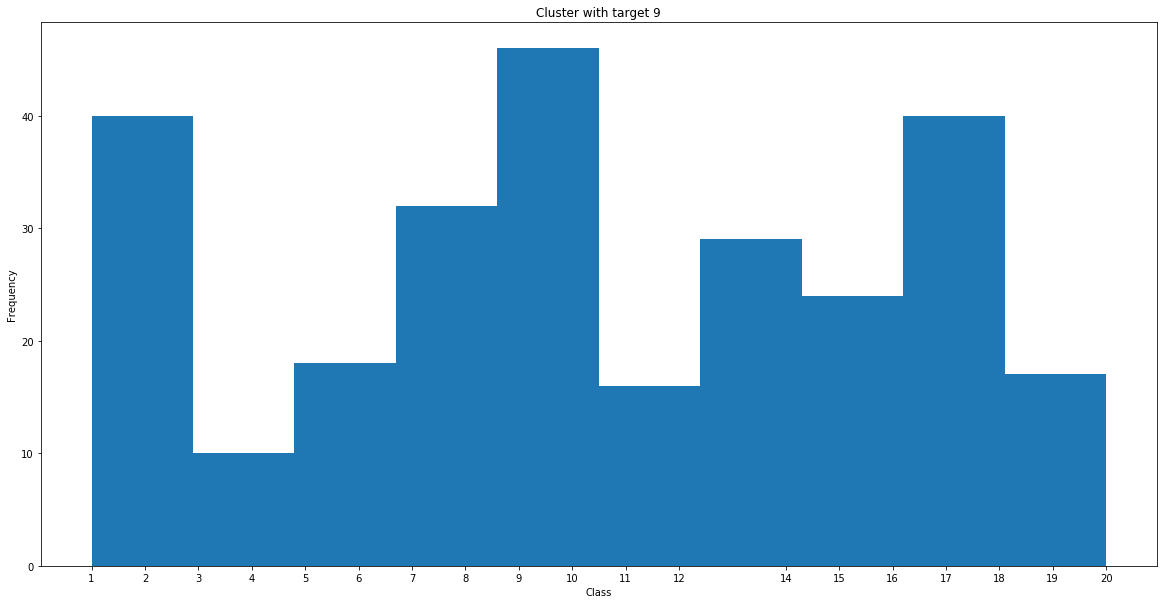

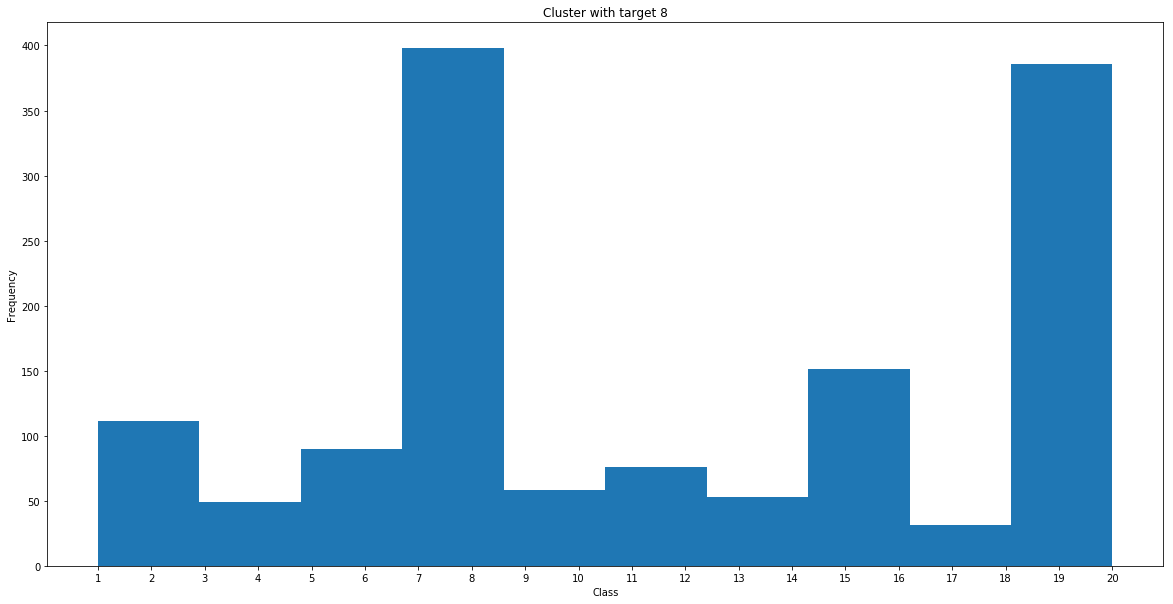

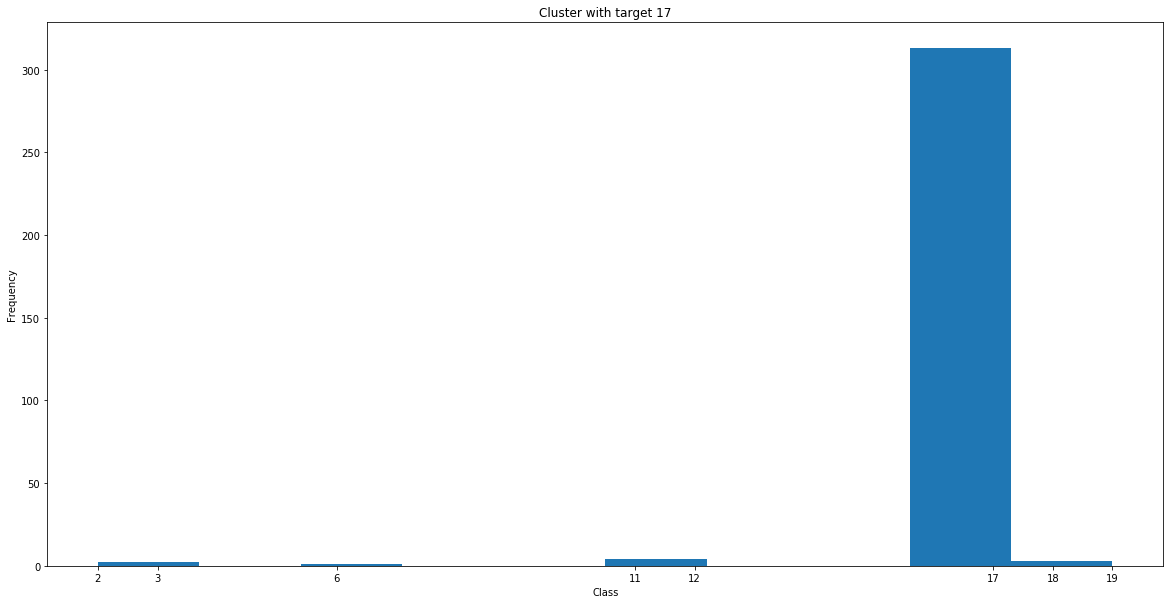

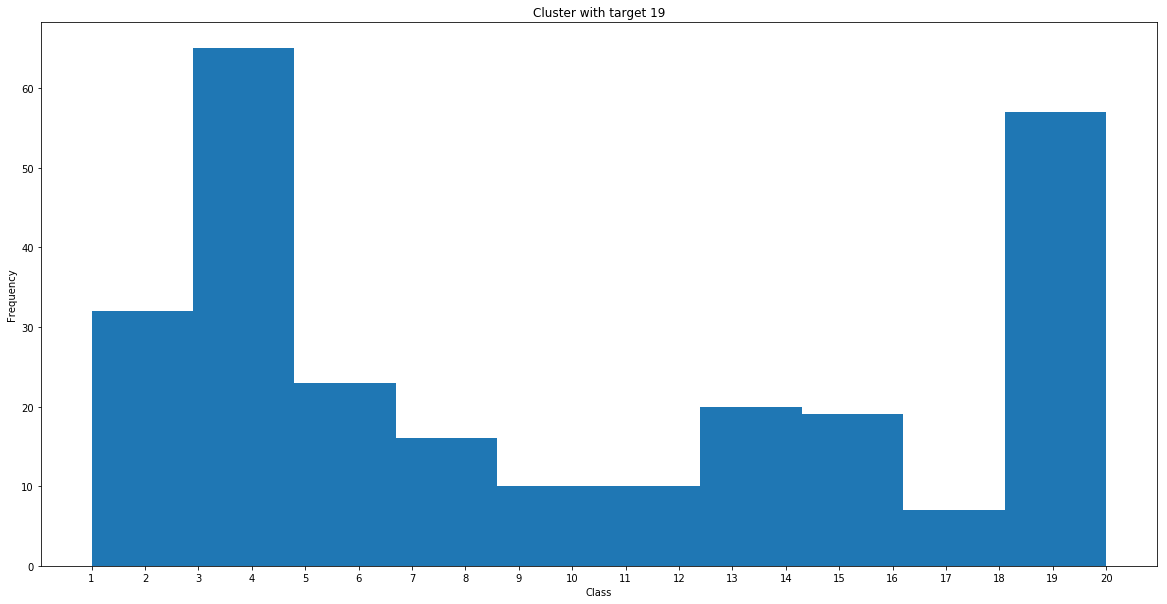

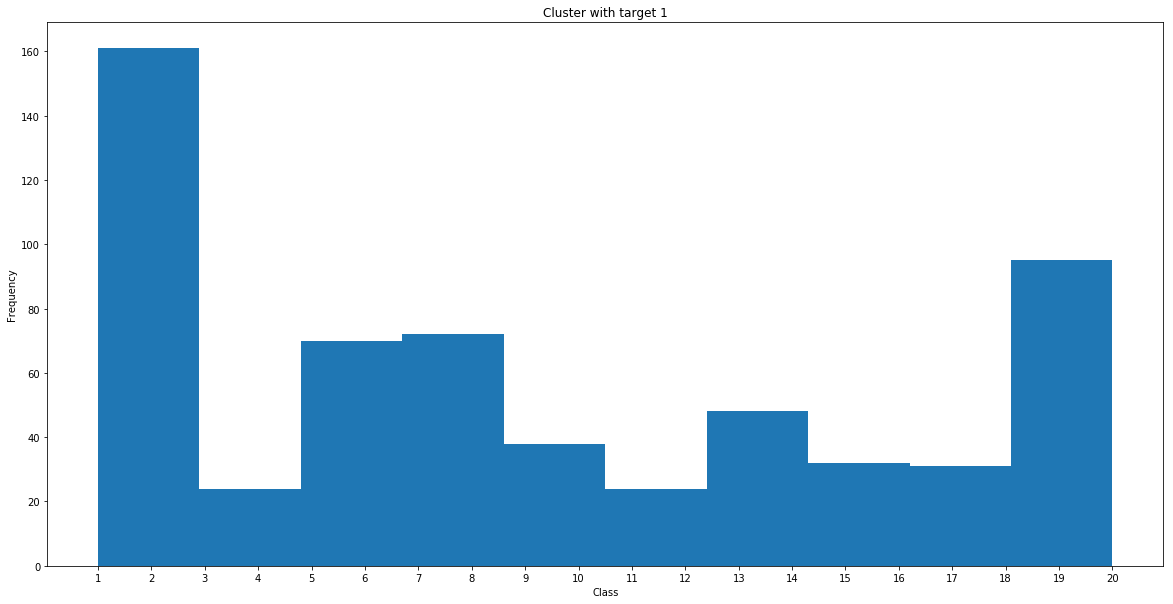

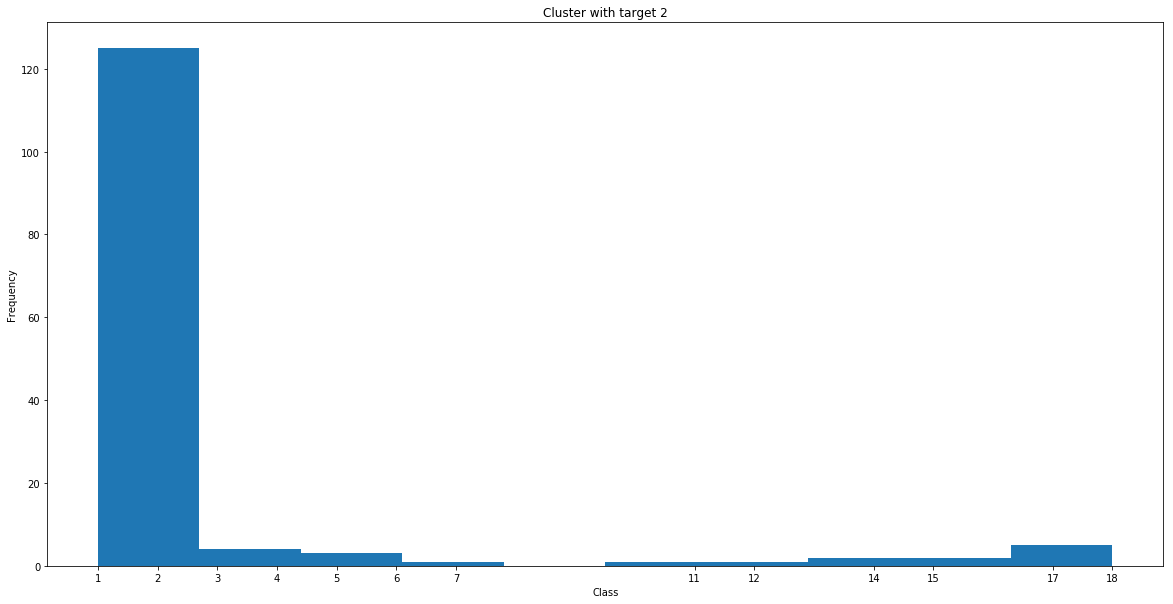

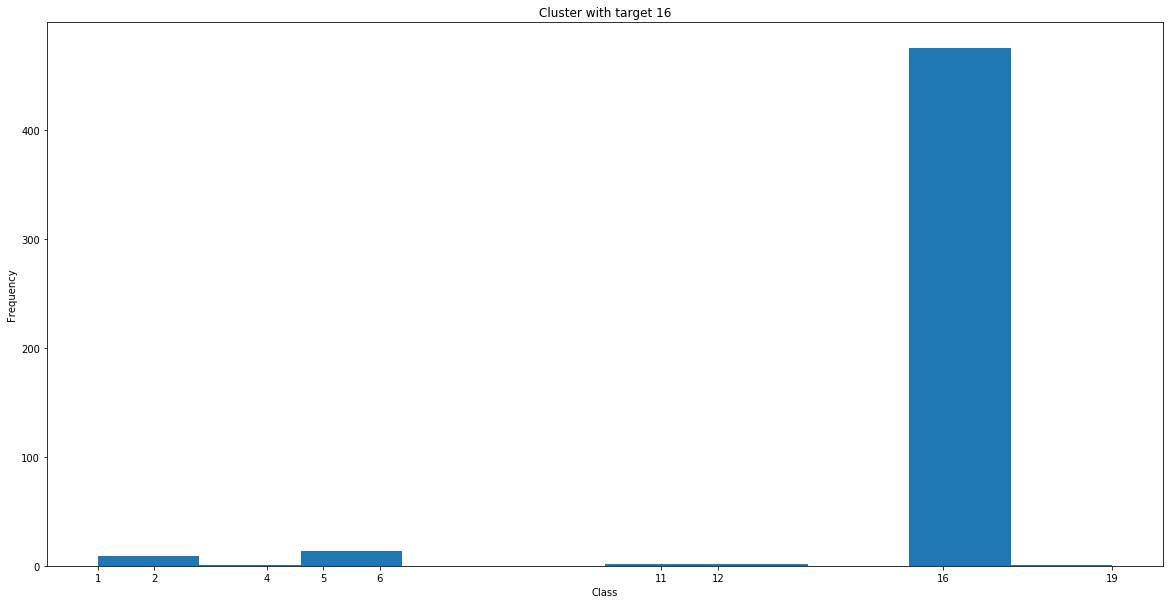

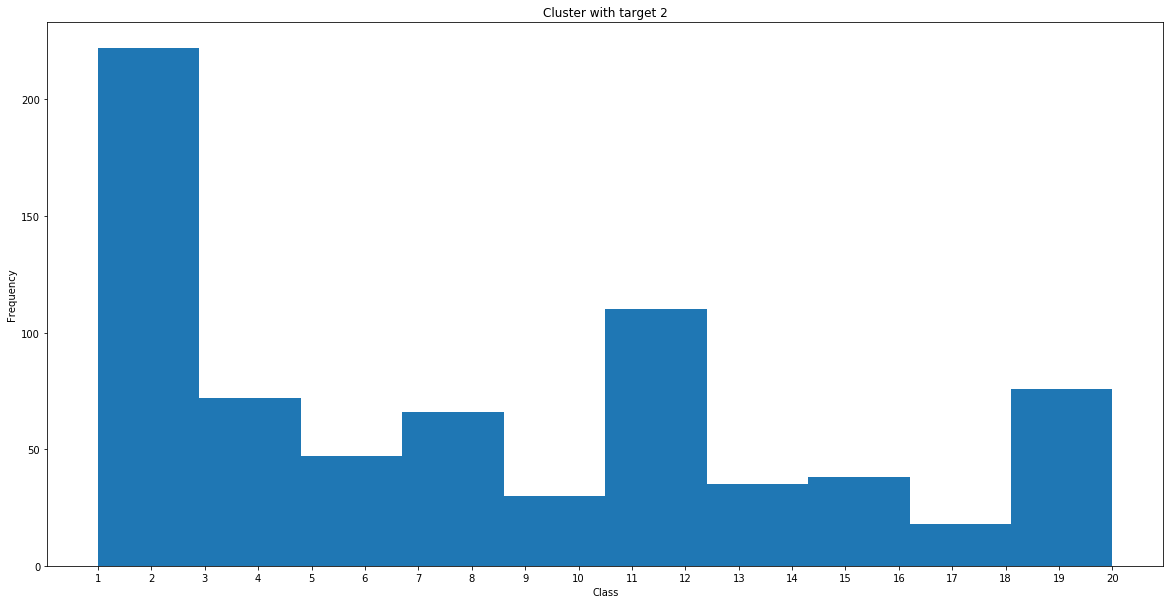

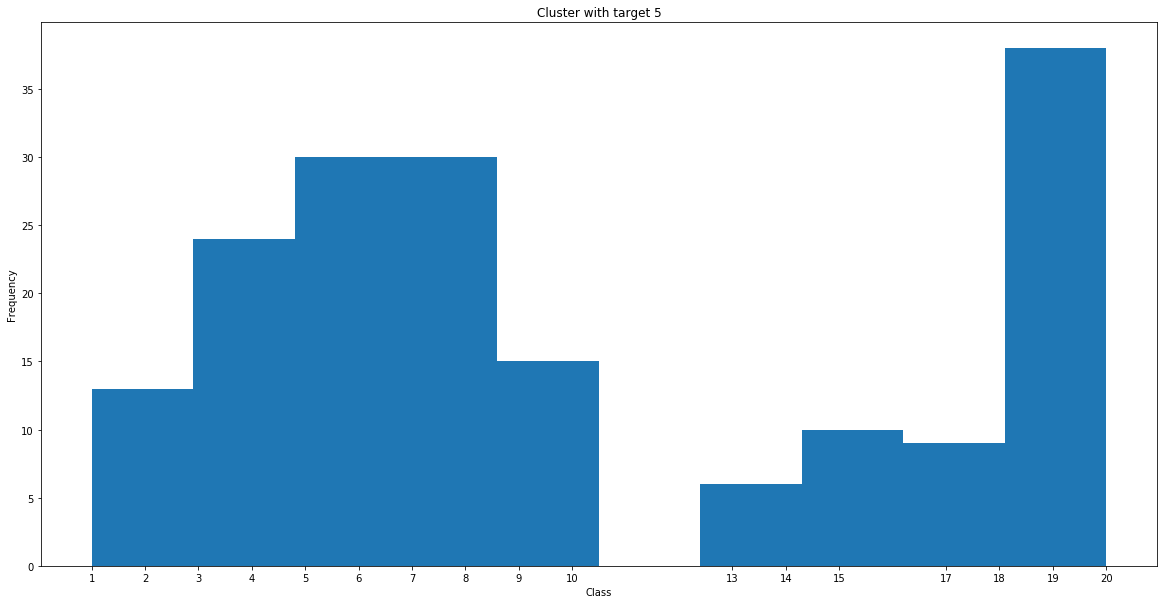

In [41]:
kmeans.plotClusterQuality()

## F1 score

In [42]:
yPrediction = kmeans.predict(xTest)
print(classification_report(yTest, yPrediction, target_names=lookupDict))

                          precision    recall  f1-score   support

         sci.electronics       0.16      0.15      0.16       393
      talk.politics.misc       0.26      0.47      0.33       396
                 sci.med       0.59      0.46      0.52       394
           comp.graphics       0.00      0.00      0.00       251
               sci.space       0.14      0.18      0.16       395
      talk.religion.misc       0.28      0.64      0.38       385
          comp.windows.x       0.35      0.66      0.46       394
 comp.os.ms-windows.misc       0.22      0.65      0.33       396
               rec.autos       0.37      0.84      0.51       398
  soc.religion.christian       0.00      0.00      0.00       392
comp.sys.ibm.pc.hardware       0.45      0.49      0.47       364
      talk.politics.guns       0.00      0.00      0.00       310
      rec.sport.baseball       0.53      0.24      0.33       319
             alt.atheism       0.00      0.00      0.00       397
         

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


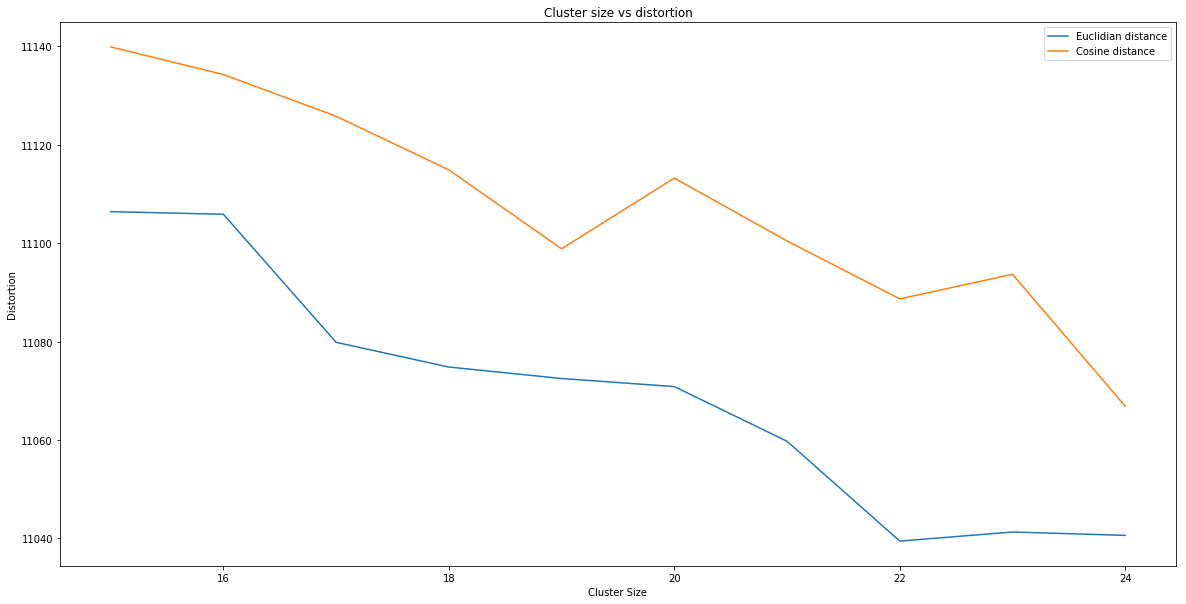

In [43]:
plt.figure(figsize=(20, 10))
plt.title("Cluster size vs distortion")
plt.plot(k, distortionsEuclidian, label = "Euclidian distance")
plt.plot(k, distortionsCosine, label = "Cosine distance")
plt.legend()
plt.xlabel("Cluster Size")
plt.ylabel("Distortion")
plt.show()

# Using SKlearn

In [50]:
k = range(15, 25)
skLearnDistortion = []

for i in k:
    kmeans = KMeans(n_clusters=i, n_init = 1)
    kmeans.fit(xTrain, yTrain)
    print(kmeans.inertia_)
    skLearnDistortion.append(kmeans.inertia_)

10898.423601257706
10889.254921620444
10882.030248377594
10842.013058913866
10828.244531912902
10824.9920592664
10832.950494078448
10790.63022011683
10777.182214747145
10757.0646606215


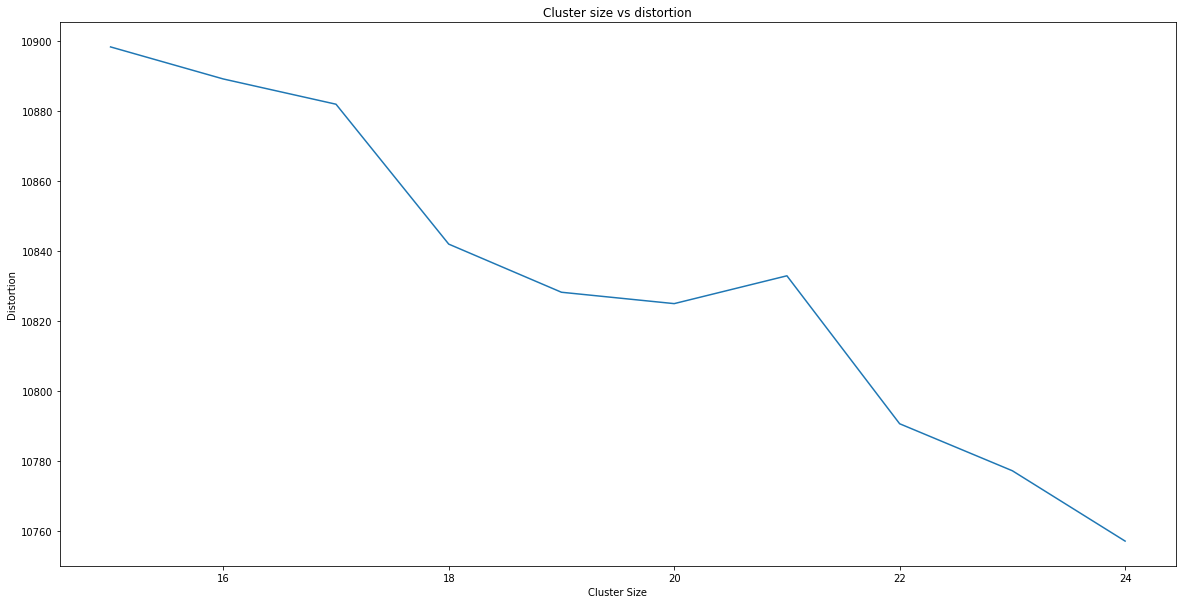

In [51]:
plt.figure(figsize=(20, 10))
plt.title("Cluster size vs distortion")
plt.plot(k, skLearnDistortion)
plt.xlabel("Cluster Size")
plt.ylabel("Distortion")
plt.show()

Optimum value for K seems to be 21

In [61]:
before = datetime.datetime.now()
kmeans = KMeans(n_clusters=21, n_init = 1)
kmeans.fit(xTrain, yTrain)
after = datetime.datetime.now()

In [62]:
print(after-before)

0:00:15.136459


In [63]:
yPrediction = kmeans.fit_predict(xTest)
print(classification_report(yTest, yPrediction, target_names=lookupDict))

                          precision    recall  f1-score   support

         sci.electronics       0.00      0.00      0.00         0
      talk.politics.misc       0.00      0.00      0.00       393
                 sci.med       0.00      0.01      0.00       396
           comp.graphics       0.00      0.00      0.00       394
               sci.space       0.01      0.00      0.00       251
      talk.religion.misc       0.00      0.00      0.00       395
          comp.windows.x       0.07      0.02      0.03       385
 comp.os.ms-windows.misc       0.02      0.01      0.01       394
               rec.autos       0.01      0.00      0.00       396
  soc.religion.christian       0.00      0.00      0.00       398
comp.sys.ibm.pc.hardware       0.00      0.00      0.00       392
      talk.politics.guns       0.08      0.02      0.03       364
      rec.sport.baseball       0.22      0.24      0.23       310
             alt.atheism       0.00      0.00      0.00       319
         

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1428: UserWarning: labels size, 21, does not match size of target_names, 20
  .format(len(labels), len(target_names))
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


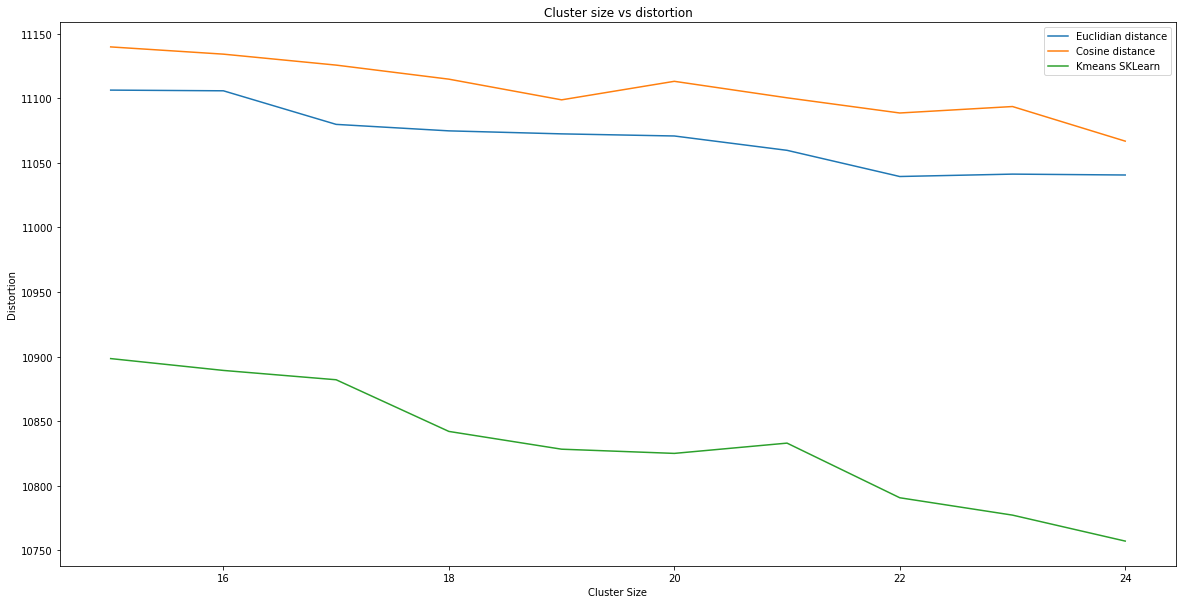

In [53]:
plt.figure(figsize=(20, 10))
plt.title("Cluster size vs distortion")
plt.plot(k, distortionsEuclidian, label = "Euclidian distance")
plt.plot(k, distortionsCosine, label = "Cosine distance")
plt.plot(k, skLearnDistortion, label = "Kmeans SKLearn")
plt.legend()
plt.xlabel("Cluster Size")
plt.ylabel("Distortion")
plt.show()